# Содержание

* [1 Поготовка данных](#1-Подготовка-данных)
    - [1.1 Загрузка данных](#1.1-Загрузка-данных)
    - [1.2 Объединение данных](#1.2-Объединение-данных)
* [2 Общий анализ данных](#2-Общий-анализ-данных)
    - [2.1 Оценка характеристик](#2.1-Оценка-характеристик)
    - [2.2 Правдоподобность значений](#2.2-Правдоподобность-значений)
* [3 Предобработка данных](#3-Предобработка-данных)
    - [3.1 Подготовка данных](#3.1-Подготовка-данных)
    - [3.2 Аугментация данных](#3.2-Аугментация-данных)
* [4 Исследовательский анализ данных](#4-Исследовательский-анализ-данных)
* [5 Отбор признаков](#5-Отбор-признаков)
* [6 Общий вывод](#6-Общий-вывод)

# Этап 1. Исследовательский анализ данных

**Задача:** Проведение исследовательского анализа данных для: 

1) Построения модели Multi-label classification. 
2) Составления рекомендательной системы.

**Источник данных:** [data_sg.zip](https://drive.google.com/drive/folders/1EtJCerFYkeXTnNYRUNSw72TP_WprqavY).

**Характер данных:** сведения о заказах в Сингапуре ([Delivery Hero Recommendation Dataset](https://drive.google.com/file/d/12N6iHczXIVX4E_KM15jxeJ_7WQ2urHFq/view)).

<div>
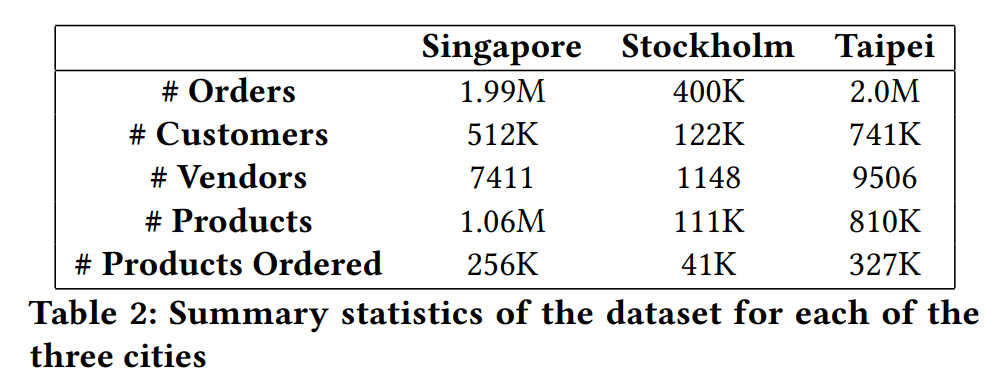
</div>

---

Согласно документации к данным, архив содержит следующие таблицы и столбцы:

Таблица `Orders`:

* `customer_id` - уникальный идентификатор пользователя
* `order_time time` - время размещения заказа
* `day_of_week` - день недели размещения заказа (0 = Воскресенье)
* `order_day` - количество дней с момента создания заказа
* `geohash` - хэш-идентификатор географического расположения размещения заказа с точностью до 5 символов
* `order_id` - уникальный идентификатор заказа
* `vendor_id` - уникальный идентификатор продавца, которому был размещён заказ

Таблица `Vendor`:

* `vendor_id` - уникальный идентификатор продавца, которому был размещён заказ
* `chain_id` - хэш-идентификатор географического расположения сети, к которой относится продавец (0 = Непринадлежность к какой-либо сети)
* `geohash` - хэш-идентификатор географического расположения размещения заказа с точностью до 5 символов
* `primary_cuisine` - кухня, на которой специализируется продавец

Таблица `Product`:

* `vendor_id` - уникальный идентификатор продавца, которому был размещён заказ
* `product_id` - уникальный идентификатор заказанного продукта 
* `name` - название продукта в соответствии с меню
* `unit_price` - стоимость за единицу продукта

---

## 1 Подготовка данных

Установка библиотек:

In [1]:
%%capture no-display
!pip install geohash2 wordcloud phik geopy

Импорт библиотек:

In [2]:
import pandas as pd
import numpy as np

import os
from typing import List, Tuple
import re

from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix

from wordcloud import WordCloud

import geohash2
from geopy.distance import geodesic

Игнорирование предупреждений:

In [3]:
import warnings
warnings.filterwarnings('ignore')

---

### 1.1 Загрузка данных

Задание функции, получения и краткого вывода данных:

In [4]:
def get_data(path: str) -> pd.DataFrame:
    '''Save data to variable and display head of it.
    
    Args:
    - path (str) - path to data
    '''
    data = pd.read_csv(path, index_col=0) # 1. get data
    
    display(data.head(3)) # 2. display data
    print('Data shape:', data.shape) # 3. print data shape
    
    return data

---

Задание пути до папки с данными:

In [5]:
PATH = 'data/'

Выведение на экран содержимого папки с данными:

In [6]:
os.listdir(PATH)

['non_similar_order_id_test.txt',
 'non_similar_order_id_train.txt',
 'orders_sg.txt',
 'orders_sg_test.txt',
 'orders_sg_train.txt',
 'order_id_with_similar_product_id_test.txt',
 'order_id_with_similar_product_id_train.txt',
 'preprocessed_data',
 'products_sg.txt',
 'vendors_sg.txt']

Загрузка данных:

In [7]:
data_products = get_data(os.path.join(PATH, 'products_sg.txt'))

,vendor_id,product_id,name,unit_price
0,15bbf316,59099e089514,Meat & Seafood Combo 海鲜套餐,0.0036
1,e7b24dc0,52e1017fdbd9,Sausage Egg McMuffin® Meal,0.0024
2,e7b24dc0,fcb7110cd932,Scrambled Egg Burger w Chicken Meal,0.0024


Data shape: (1066840, 4)


Загрузка данных:

In [8]:
data_vendors = get_data(os.path.join(PATH, 'vendors_sg.txt'))

,vendor_id,chain_id,geohash,primary_cuisine
0,b160c319,d2786168,w21z6,mexican
1,9c8f010e,d2786168,w21ze,mexican
4,03eb25e1,5055ab25,w21ze,bak kut teh


Data shape: (7411, 4)


Загрузка данных:

In [9]:
data_orders = get_data(os.path.join(PATH, 'orders_sg.txt'))

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days


Data shape: (4023005, 8)


Загрузка данных:

In [10]:
data_orders_train = get_data(os.path.join(PATH, 'orders_sg_train.txt'))

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day
5,f374c8c54c,w21zt,1,21830106,f245bdf79350,4,19:03:03,61 days
6,f374c8c54c,w21zt,1,21830106,146127be77d4,4,19:03:03,61 days
7,f374c8c54c,w21zt,1,21830106,6c108c0fb2b9,4,19:03:03,61 days


Data shape: (3431870, 8)


Загрузка данных:

In [11]:
data_orders_test = get_data(os.path.join(PATH, 'orders_sg_test.txt'))

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days


Data shape: (591135, 8)


Соотнесение суммы длинн тренировочной и тестовой выборки с общей выборкой:

In [12]:
print(
    'length of train + test = length of data -->',
    data_orders_train.shape[0] + data_orders_test.shape[0] == data_orders.shape[0]
)

length of train + test = length of data --> True


Соотнесение суммы длинн уникальных идентификаторов тренировочной и тестовой выборки с общей выборкой:

In [13]:
print(
    'length of unique indexes in train + text = length of data -->',
    len(set(list(data_orders_train.index) + list(data_orders_test.index))) == data_orders.shape[0]
)

length of unique indexes in train + text = length of data --> True


>**Вывод**
>
>* Далее преобразования будут произведены на уже разделённых наборах данных `orders_train` и `orders_test`.
>
>* Значения таблиц `products_se` и `vendors_se` содержат недостающие в заказах значения и будут добавлены в наборы данных `orders_train` и `orders_test` по внешним ключам.

---

### 1.2 Объединение данных

Задание функции объединения набора данных с таблицой:

In [14]:
def merge_data_with_products_and_vendors(df: pd.DataFrame, 
                                         df_to_merge: pd.DataFrame,
                                         on_col: str) -> pd.DataFrame:
    
    '''Merge two dataframes on column name.
    
    Args:
    - df (pd.DataFrame) - initial dataframe
    - df_to_merge (pd.DataFrame) - dataframe to be merged
    - on_col (str) - name pf columns to merge dataframes
    '''
    
    result = df.merge(df_to_merge, on=on_col) # 1. merge dataframes
    
    display(result.head(3)) # 2. display data
    print('Data shape:', result.shape) # print data shape
    
    return result

---

Переименовывание столбцов таблицы `vendor`:

In [15]:
data_vendors.columns = [col if col not in ['geohash'] else f'{col}_vendor' for col in data_vendors.columns]
data_vendors.columns

Index(['vendor_id', 'chain_id', 'geohash_vendor', 'primary_cuisine'], dtype='object')

Объединение таблиц `products` и `vendors`:

In [16]:
data_products_vendors = data_products.merge(data_vendors, on='vendor_id') \
                                     .drop('vendor_id', axis=1)
data_products_vendors.head(3)

,product_id,name,unit_price,chain_id,geohash_vendor,primary_cuisine
0,59099e089514,Meat & Seafood Combo 海鲜套餐,0.0036,434020fb,w21zs,mala xiang guo
1,375687575c08,Buddy Promo Set B - 2 Ma La Tang Set + 2 Liho...,0.0092,434020fb,w21zs,mala xiang guo
2,8f9bf386600d,Noodle,0.0000,434020fb,w21zs,mala xiang guo


Объединение набора данных `data_orders_train` с таблицой `products` + `vendors`:

In [17]:
data_train = merge_data_with_products_and_vendors(
    data_orders_train, data_products_vendors, 'product_id'
)

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_vendor,primary_cuisine
0,f374c8c54c,w21zt,1,21830106,f245bdf79350,4,19:03:03,61 days,Chicken Cutlet with Rice,0.0020,NaN,w21zt,western
1,c7b610f30b,w21zt,603254,21830106,f245bdf79350,2,18:50:37,3 days,Chicken Cutlet with Rice,0.0020,NaN,w21zt,western
2,f374c8c54c,w21zt,1,21830106,146127be77d4,4,19:03:03,61 days,Chicken Chop,0.0028,NaN,w21zt,western


Data shape: (3431980, 13)


Объединение набора данных `data_orders_test` с таблицой `products` + `vendors`:

In [18]:
data_test = merge_data_with_products_and_vendors(
    data_orders_test, data_products_vendors, 'product_id'
)

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_vendor,primary_cuisine
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days,201. Japanese Garlic Karaage Don,0.006,66c9978d,w21z7,ramen
1,38ba08bfcd,w21z7,215269,212753d2,783e85338f1c,4,18:38:36,89 days,201. Japanese Garlic Karaage Don,0.006,66c9978d,w21z7,ramen
2,79fc1bf654,w21ze,529642,212753d2,783e85338f1c,6,19:27:37,84 days,201. Japanese Garlic Karaage Don,0.006,66c9978d,w21z7,ramen


Data shape: (591153, 13)


Сохранение исходных размеров наборов данных:

In [19]:
data_train_init_shape = data_train.shape
data_test_init_shape = data_test.shape

>**Вывод**
>
>* Прежде чем приступать к исследовательскому анализу данных, необходимо произвести общий анализ данных на предмет пропущенных значений, аномалий, выбросов, дубликатов и несоответствующих типов данных, а также последующую их предобработку в случае наличия предполагающих её факторов.

---

## 2 Общий анализ данных

Задание функции, выводящей соотношение фильтрованных значений ко всему набору данных:

In [20]:
def print_share(title: str, df_filtered_len: int, df: pd.DataFrame = None) -> None:
    '''Print quantity of filtered data and its share to total data.
    
    Args:
    - title (str) - name of filtered dataframe
    - df_filtered_len (int) - length of filtered dataframe
    - df (pd.DataFrame, optional) - initial dataframe. Defaults to None
    '''
    
    print(f'{title.capitalize()}:', df_filtered_len)
    
    if df is not None:
        print(
            f'Share of {title} to total train data:', 
            round(df_filtered_len / df.shape[0] * 100, 2),
            '%'
        )

---

### 2.1 Оценка характеристик

Выведение на экран числового описания столбцов:

In [21]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431980 entries, 0 to 3431979
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   customer_id      object 
 1   geohash          object 
 2   order_id         int64  
 3   vendor_id        object 
 4   product_id       object 
 5   day_of_week      int64  
 6   order_time       object 
 7   order_day        object 
 8   name             object 
 9   unit_price       float64
 10  chain_id         object 
 11  geohash_vendor   object 
 12  primary_cuisine  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 340.4+ MB


Выведение на экран уникальных значений столбцов:

In [22]:
for col in data_train.columns:
    print(col.upper())
    print(data_train[col].sort_values().unique())
    print('\n---\n')

CUSTOMER_ID
['000032bc12' '0000763b91' '0000a85cca' ... 'ffff8b9e09' 'ffff977a47'
 'ffffa3cd1a']

---

GEOHASH
['w21xj' 'w21xm' 'w21xn' 'w21xp' 'w21xq' 'w21xr' 'w21xw' 'w21xx' 'w21xz'
 'w21z1' 'w21z2' 'w21z3' 'w21z4' 'w21z5' 'w21z6' 'w21z7' 'w21z8' 'w21z9'
 'w21zb' 'w21zc' 'w21zd' 'w21ze' 'w21zf' 'w21zg' 'w21zk' 'w21zm' 'w21zq'
 'w21zr' 'w21zs' 'w21zt' 'w21zu' 'w21zv' 'w21zw' 'w21zx' 'w21zy' 'w21zz'
 'w238p' 'w23b0' 'w23b1' 'w23b3' 'w23b4' 'w23b5' 'w23b6' 'w23b7' 'w23bh']

---

ORDER_ID
[      1       2       3 ... 1999997 1999998 1999999]

---

VENDOR_ID
['0002b34d' '00047fb9' '0006d2e7' ... 'fffc214f' 'fffd7a7e' 'fffdb009']

---

PRODUCT_ID
['000001609712' '0000171b3f82' '0000361d004d' ... 'ffff1a3ba297'
 'ffffe056a504' 'ffffe980d132']

---

DAY_OF_WEEK
[0 1 2 3 4 5 6]

---

ORDER_TIME
['00:00:00' '00:00:01' '00:00:02' ... '23:59:57' '23:59:58' '23:59:59']

---

ORDER_DAY
['0 days' '1 days' '10 days' '11 days' '12 days' '13 days' '14 days'
 '15 days' '16 days' '17 days' '18 days' '19

>* Значения столбцов `geohash` и `geohash_vendor` отличаются - в ходе исследовательского анализа можно рассмотреть расположение покупателя относительно сети продавца.
>
>* Необходимо проверить значения столбца `order_id` на отсутствие дубликатов.
>
>* Дни недели будет удобнее перевести в формат: c 0 - Восресенье на 7 - Воскресенье.
>
>* Из значений столбца `order_day` необходимо убрать ` days` и привести к типу данных `int64`.
>
>* Значения столбца `name` будут приведены к нижнему регистру, очищены от лишних пробелов и рассмотрены с точки зрения лексикографии, а в ходе предподготовки набора данных к построению модели и обучению переведены в векторный вид.
>
>* Необходимо проверить значения столбца `unit_price` на наличие аномалий или выбросов.

---

Удаление из столбцов `order_day` лишних компонент и приведение к числовому типу данных:

In [23]:
replace_order_day = lambda x: x.str.replace(' days', '').astype('int64')

data_train['order_day'] = replace_order_day(data_train['order_day'])
data_test['order_day'] = replace_order_day(data_test['order_day'])

Выведение на экран характеристик числовых столбцов:

In [24]:
data_train[['order_day', 'unit_price']].describe().T

,count,mean,std,min,25%,50%,75%,max
order_day,3431980.0,37.664732,21.441865,0.0,20.0000,38.0000,56.000,75.0
unit_price,3431980.0,0.003410,0.003368,0.0,0.0016,0.0028,0.004,1.0


>* Необходимо проверить характер происхождения нулей в столбцах `order_day` и `unit_price`.

---

Выведение на экран количества явных пропущенных значений:

In [25]:
data_train.isna().sum()

customer_id             0
geohash                 0
order_id                0
vendor_id               0
product_id              0
day_of_week             0
order_time              0
order_day               0
name                    0
unit_price              0
chain_id           527259
geohash_vendor          0
primary_cuisine         0
dtype: int64

>* Согласно документации к данных, пропущенные значения в столбце `chain_id` означают непринадлежность продавца к какой-либо сети. Необходимо заменить эти значения на `undefined`.

Замена пропущенных значений в столбце `chain_id`:

In [26]:
replace_chain_id = lambda x: x.fillna('undefined')

data_train['chain_id'] = replace_chain_id(data_train['chain_id'])
data_test['chain_id'] = replace_chain_id(data_test['chain_id'])

Выведение на экран количественного соотношения значений столбца для проверки применённых изменений:

In [27]:
data_train['chain_id'].value_counts(ascending=False)

chain_id
undefined    527259
21d7cbf7      81503
24975bf7      56055
0f494195      49291
45b7cc87      41523
              ...  
9c804d32          1
7cc5ec18          1
82c0670d          1
d716d229          1
7ff86a7d          1
Name: count, Length: 1842, dtype: int64

---

Выведение на экран количества явных дубликатов строк и их доли относительно всего набора данных:

In [28]:
print_share('total duplicates', data_train.duplicated().sum(), data_train)

Total duplicates: 84975
Share of total duplicates to total train data: 2.48 %


>* Необходимо удалить явные дубликаты из наборов данных.

Удаление явных дубликатов из наборов данных:

In [29]:
drop_duplicates_from_df = lambda x: x.drop_duplicates().reset_index(drop=True)

data_train = drop_duplicates_from_df(data_train)
data_test = drop_duplicates_from_df(data_test)

Выведение на экран количества явных дубликатов для проверки применённых изменений:

In [30]:
print_share('total duplicates', data_train.duplicated().sum())

Total duplicates: 0


---

### 2.2 Правдоподобность значений

**2.2.1 Столбец `order_id`**

Задание функции, сохраняющей данные в файл:

In [31]:
def save_file(data: List[int], name: str) -> None:
    '''Save list of integers to a file.
    
    Args:
    - data (List[int]) - list of integers
    - name (str) - file name
    '''
    
    with open(os.path.join(PATH, name), 'w') as file:
        file.write('\n'.join([str(x) for x in data]))

Задание функции, загружающей данные из файла:

In [32]:
def load_file(name: str) -> List[int]:
    '''Load list of integers from a file.
    
    Args:
    - name (str) - file name
    '''
    
    file_data = []
    
    with open(os.path.join(PATH, name), 'r') as file:
        for line in file:
            file_data.append(int(line.strip()))
    
    return file_data

Задание функции, проверяющей уникальность идентификаторов продуктов и принадлежность позиций одному заказу при неуникальных идентификаторах заказов (если операция проверки уже была проведена, то подгружающей идентификаторы заказов из .csv-файлов):

In [33]:
def check_product_id_order_id(df: pd.DataFrame, 
                              indexes_order_id: List[int], 
                              name: str = '') -> Tuple[List[int]]:
    
    '''Check if product_id is unique while order_id is non unique & if all of non unique order_id belongs to the same order.
    
    Args:
    - df (pd.DataFrame) - initial dataframe
    - indexes_order_id (List[int]) - list of indexes of non unique order_id
    - name (str, optional) - end of file name
    '''
    
    order_id_with_similar_product_id = []
    non_similar_order_id = []
    
    names = [f'order_id_with_similar_product_id{name}.txt', f'non_similar_order_id{name}.txt']
    
    if names[0] not in os.listdir(PATH) or names[1] not in os.listdir(PATH):

        for index in tqdm(indexes_order_id, 'Checking'):
            df_filtered = df[df['order_id'] == index]
            df_filtered_len = df_filtered.shape[0]

            if len(df_filtered['product_id'].unique()) != df_filtered_len: # 1. product_id is not unique
                order_id_with_similar_product_id.append(index)
            
            df_filtered_drop = df_filtered.drop(['product_id', 'name', 'unit_price'], axis=1)

            if df_filtered_drop.duplicated().sum() + 1 != df_filtered_len: # 2. order_id belongs to different orders
                non_similar_order_id.append(index)
        
        save_file(order_id_with_similar_product_id, names[0]) # 3. save results
        save_file(non_similar_order_id, names[1])
    
    else: # 4. load data
        print('Loaded data\n')
        order_id_with_similar_product_id = load_file(names[0])
        non_similar_order_id = load_file(names[1])
    
    print('Total order_id with similar product_id:', len(order_id_with_similar_product_id))
    print('Total non similar order_id:', len(non_similar_order_id))
    
    return order_id_with_similar_product_id, non_similar_order_id

---

Выведение на экран количества строк набора данных с одинаковыми идентификаторами заказов:

In [34]:
data_train['order_id'].value_counts().sort_values(ascending=False)

order_id
25147      29
1640706    28
778311     27
1739120    27
1108194    26
           ..
358787      1
814041      1
1253379     1
1409574     1
1999697     1
Name: count, Length: 1709414, dtype: int64

Получение количественного распределения значений `order_id`:

In [35]:
get_not_unique_order_id_index = lambda df: list(
    pd.DataFrame(df['order_id'].value_counts()).query('count > 1').index
)

not_unique_order_id_train = get_not_unique_order_id_index(data_train)
not_unique_order_id_test = get_not_unique_order_id_index(data_test)

Выведение на экран количества неуникальных идентификаторов заказов и их доли относительно всего набора данных:

In [36]:
print_share('non unique order_id', len(not_unique_order_id_train), data_train)

Non unique order_id: 871082
Share of non unique order_id to total train data: 26.03 %


>* Необходимо изучить происхождение такого количества заказов с повторяющимися идентификаторами.

Выведение на экран строк набора данных с одним из неуникальных идентификаторов заказов:

In [37]:
data_train[data_train['order_id'] == not_unique_order_id_train[0]]

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_vendor,primary_cuisine
52888,ce9649f62b,w21zc,25147,40516520,3b8fc7e92644,3,21:04:51,18,Salmon Sushi,0.0012,be5cc24e,w21zc,sushi
52923,ce9649f62b,w21zc,25147,40516520,d1340e6b05d1,3,21:04:51,18,Kake Udon,0.0020,be5cc24e,w21zc,sushi
1227328,ce9649f62b,w21zc,25147,40516520,000581f4218a,3,21:04:51,18,Yaki Corn Sushi,0.0012,be5cc24e,w21zc,sushi
1227331,ce9649f62b,w21zc,25147,40516520,237329337ca7,3,21:04:51,18,Tamago Sushi,0.0008,be5cc24e,w21zc,sushi
1227347,ce9649f62b,w21zc,25147,40516520,0137dc06e7f1,3,21:04:51,18,Inari Sushi,0.0008,be5cc24e,w21zc,sushi
1227359,ce9649f62b,w21zc,25147,40516520,eb1ff4290818,3,21:04:51,18,California Handroll,0.0012,be5cc24e,w21zc,sushi
1227370,ce9649f62b,w21zc,25147,40516520,758f22950f8f,3,21:04:51,18,Edo Tamago Sushi,0.0012,be5cc24e,w21zc,sushi
1227381,ce9649f62b,w21zc,25147,40516520,dba71f7013e7,3,21:04:51,18,Kani Black Pepper,0.0012,be5cc24e,w21zc,sushi
1227384,ce9649f62b,w21zc,25147,40516520,f142bd6c9f76,3,21:04:51,18,Unagi & Yuzu Prawn + 1 Miso Soup,0.0060,be5cc24e,w21zc,sushi
1227388,ce9649f62b,w21zc,25147,40516520,eb8865d4fc8c,3,21:04:51,18,Scallop Mentaiyaki,0.0028,be5cc24e,w21zc,sushi


>* Можно предположить, что: 1) все продукты были заказаны в рамках одного заказа, поскольку заметно различие только в столбцах `product_id`, `unit_price` и `name`; 2) было заказано несколько одинаковых позиций.
>
>В документации же содержится следующая заметка:
>```
...For instance, in Taipei there are details for 810K unique products out of which only 327K have associated orders (a mere 40% of the total). This situation frequently occurs due to a number of factors involving changes to product names (spelling corrections, marketing labels, etc.), portion/quantity changes, price modification, seasonal menu changes and more. This requires meticulous exploration of the dataset to come up with novel preprocessing techniques for different downstream tasks (not limited to recommendations alone). Multiple languages add an additional layer of complexity to such methods...
>```
>
>* Необходимо проверить, отличается ли `product_id` при неуникальном `order_id`.
>
>* Необходимо проверить, действительно ли все неуникальные идентификаторы заказов соответствуют нескольким позициям в рамках одного заказа.

Проверка уникальности значений `product_id` и принадлежности позиций одному заказу при неуникальных идентификаторах заказа:

In [38]:
order_id_with_similar_product_id_train, \
non_similar_order_id_train = check_product_id_order_id(data_train, not_unique_order_id_train, '_train')

Loaded data

Total order_id with similar product_id: 86
Total non similar order_id: 95


In [39]:
order_id_with_similar_product_id_test, \
non_similar_order_id_test = check_product_id_order_id(data_test, not_unique_order_id_test, '_test')

Loaded data

Total order_id with similar product_id: 15
Total non similar order_id: 17


>* В наборе данных есть заказы, соответствующие заметке из документации - то есть представляющие собой неявные дубликаты строк, которые можно удалить.
>
>* Часть позиций с неуникальным номером заказа не были заказаны в рамках одного заказа.

Выведение на экран количества несовпадающих идентификаторов неуникальных заказов в полученных списках:

In [40]:
print(
    'Not in the intesection:',
    len(set(order_id_with_similar_product_id_train) ^ set(non_similar_order_id_train))
)

Not in the intesection: 9


>* Подавляющее большинство неуникальных идентификаторов заказов соответствует как неявным дубликатам строк, так и позициям, заказанным не в рамках одного заказа.

Выведение на экран образца найденных неуникальных идентификаторов заказов:

In [41]:
data_train[data_train['order_id'] == order_id_with_similar_product_id_train[0]]

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_vendor,primary_cuisine
798693,bd8f89ca53,w21zt,152159,a06f1cbf,5b89c2e3313b,5,18:14:04,41,I09. Butter Diced Chicken with Rice 奶皇鸡丁饭,0.0028,undefined,w21xr,chinese
798694,bd8f89ca53,w21zt,152159,a06f1cbf,5b89c2e3313b,5,18:14:04,41,I09. Butter Diced Chicken with Rice 奶皇鸡丁饭,0.0032,f24465fd,w21zt,chinese
2500604,bd8f89ca53,w21zt,152159,a06f1cbf,94812c3b58cf,5,18:14:04,41,I19. Mixed Ingredients Hor Fun 什锦滑蛋河粉,0.0020,f24465fd,w21zt,chinese
2598500,bd8f89ca53,w21zt,152159,a06f1cbf,3cfc6048b8eb,5,18:14:04,41,I15. Mee Goreng 海鲜马来炒面,0.0024,undefined,w21xr,chinese
2598508,bd8f89ca53,w21zt,152159,a06f1cbf,2f9ddb3f502c,5,18:14:04,41,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028,undefined,w21xr,chinese
2598509,bd8f89ca53,w21zt,152159,a06f1cbf,2f9ddb3f502c,5,18:14:04,41,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028,f24465fd,w21zt,chinese
2598534,bd8f89ca53,w21zt,152159,a06f1cbf,6444c0d6f126,5,18:14:04,41,I22. Yang Zhou Fried Rice 扬州炒饭,0.0020,f24465fd,w21zt,chinese


>* Необходимо удалить встречаются в наборе записи идентичные описанному в документации поведению записи, в которых есть описанные в документации отличия.
>
>* Необходимо удалить записи, сделанные не в рамках одного заказа с неуникальным номером.

Выведение на экран количества строк набора данных с одинаковыми идентификаторами продуктов при неуникальных идентификаторах заказа и их доли относительно всего набора данных:

In [42]:
print_share(
    'order_id with similar product_id',
    data_train[data_train['order_id'].isin(order_id_with_similar_product_id_train)].shape[0],
    data_train
)

Order_id with similar product_id: 252
Share of order_id with similar product_id to total train data: 0.01 %


Выведение на экран количества строк набора данных с неуникальными номерами заказов и их доли относительно всего набора данных:

In [43]:
print_share(
    'non similar order_id',
    data_train[data_train['order_id'].isin(non_similar_order_id_train)].shape[0],
    data_train
)

Non similar order_id: 272
Share of non similar order_id to total train data: 0.01 %


Удаление неявных дубликатов строк по неуникальным идентификаторам заказов и неуникальным идентификаторам продуктов:

In [44]:
drop_order_id = lambda x, y: x.drop(x[x['order_id'].isin(y)].index).reset_index(drop=True)

data_train = drop_order_id(data_train, order_id_with_similar_product_id_train)
data_test = drop_order_id(data_test, order_id_with_similar_product_id_test)

data_train = drop_order_id(data_train, non_similar_order_id_train)
data_test = drop_order_id(data_test, non_similar_order_id_test)

---

**2.2.2 Столбец `unit_price`**

Задание функции, выводящей графики распределения значений в переданном столбце:

In [45]:
def plot_box_hist(df: pd.DataFrame, col_name: str, n_bins: int = 60) -> None:
    '''Plot boxplot and histogram.
    
    Args:
    - df (pd.DataFrame) - initial dataframe
    - col_name (str) - column name
    - n_bins (int, optional) - number of bins. Defaults to 60
    '''
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle(f'Values distribution on {col_name}', fontsize=12)
    
    ax[0].boxplot(df[col_name])
    ax[0].set_xticks([1], [col_name])
    ax[0].set_ylabel('frequency')
    ax[0].grid()
    
    ax[1].hist(df[col_name], bins=n_bins)
    ax[1].set_xlabel(col_name)
    ax[1].set_ylabel('frequency')
    ax[1].grid()
    
    plt.show()

---

Выведение графиков распределения значений в столбце:

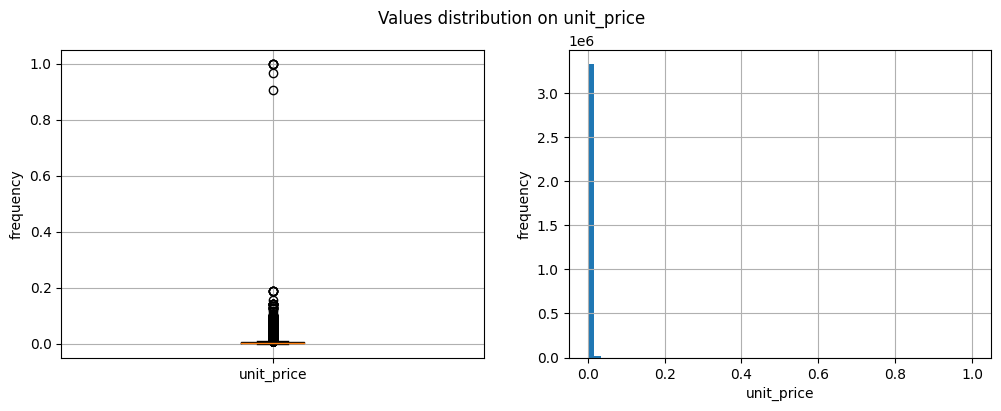

In [46]:
plot_box_hist(data_train, 'unit_price')

>* Необходимо проанализировать происхождение нулевых значений.
>
>* Значения свыше 0.2 являются выбросами.

Получение набора данных с нулевыми значениями стоимости:

In [47]:
df_unit_price_zero = data_train.query('unit_price == 0.0')

Выведение на экран количества нулевых значений стоимости и их доли относительно всего набора данных:

In [48]:
print_share('unit_price equal to 0.0', df_unit_price_zero.shape[0], data_train)

Unit_price equal to 0.0: 31354
Share of unit_price equal to 0.0 to total train data: 0.94 %


>* Поскольку невозможно определить происхождение нулевых значений, возникших при объединении набора данных с исходной таблицей `data_products`, эти значения можно удалить.

Удаление строк со стоимостью `< 0` и `> 0.2`:

In [49]:
filter_df_with_unit_price = lambda df: df.query('0 < unit_price < 0.2').reset_index(drop=True)

data_train = filter_df_with_unit_price(data_train)
data_test = filter_df_with_unit_price(data_test)

Выведение графиков распределения значений в столбце для проверки применённых изменений:

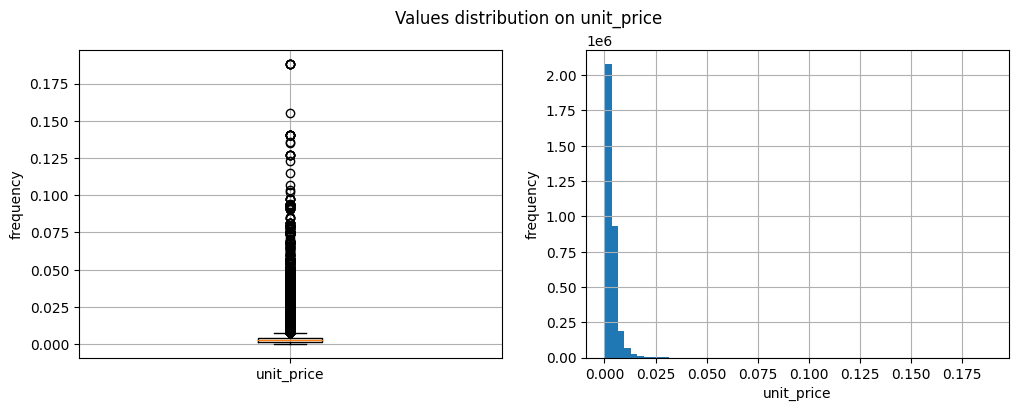

In [50]:
plot_box_hist(data_train, 'unit_price')

>* Необходимо проверить характер происхождения нулей в столбцах `order_day` и `unit_price`.

---

**Столбец `order_day`**

Выведение графиков распределения значений в столбце:

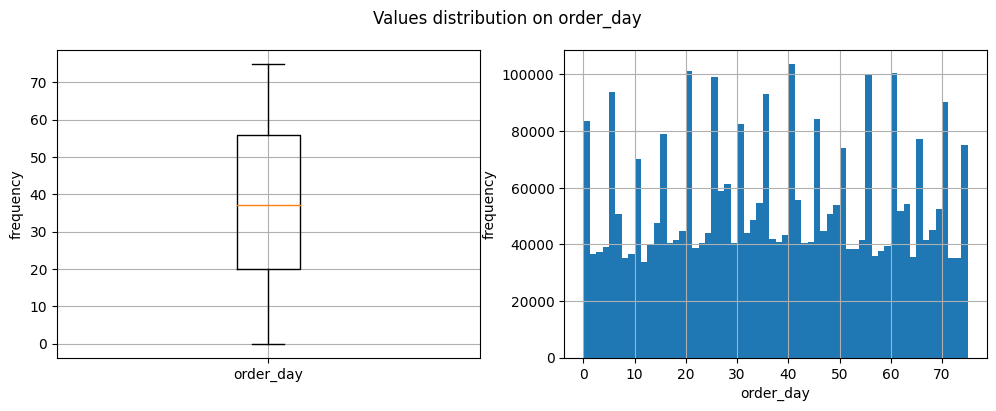

In [51]:
plot_box_hist(data_train, 'order_day')

>* Согласно документации, столбец содержит количество дней, прошедших с момента оформления заказа. Таким образом, нулевые значения не являются выбросами.
>
>* Данные имеют нормальное распределение.

>**Вывод**
>
>* Далее необходимо обработать данные согласно оставшимся указанным при общем анализе рекомендациям для столбцов `day_of_week` и `name`.

---

## 3 Предобработка данных

### 3.1 Подготовка данных

**Столбец `day_of_week`**

Изменение формата столбца (0 - Воскресенье на 7 - Воскресенье):

In [52]:
change_weekday = lambda x: 7 if x == 0 else x

data_train['day_of_week'] = data_train['day_of_week'].apply(change_weekday)
data_test['day_of_week'] = data_test['day_of_week'].apply(change_weekday)

Выведение на экран уникальных значений столбца для проверки применённых изменений:

In [53]:
data_train['day_of_week'].sort_values().unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

---

**Столбец `name`**

Задание функции, очищающей значения от нежелательных символов:

In [54]:
def clean_names(data: pd.Series) -> pd.Series:
    '''Clean sentences from chineese characters, punctuation, digits, single characters and extra spaces.
    
    Args:
    - data (pd.Series) - dataframe column
    '''
    
    updated_col = pd.Series([
        re.sub(r'\b(\w+)( \1\b)+', r'\1', # 6. remove duplicated words
            re.sub(r'\b\w{1,2}\b', '', # 5. remove characters less than 3 characters
                re.sub('\d+', '', # 4. remove digits
                    re.sub('[^\x00-\x7f]', '', # 3. remove chineese characters
                        re.sub('[^\w\s]', ' ', name) # 2. remove punctuation
                    )
                )
            )
        )
        for name in data.str.lower() # 1. lower letters
    ])
    
    updated_col = updated_col.apply(lambda x: re.sub(' +', ' ', # 8. remove extra spaces
        ' '.join([
            re.sub(r'^([a-z])\1+$', r'', word) # 7. remove words made up of repetitive letters
            for word in x.split()
        ]).strip()) # 9. remove spaces on start and end
    )
    
    return updated_col

Задание функции, строящей график переданных данных:

In [55]:
def plot_bar(df: pd.DataFrame, col_x: str, col_y: str) -> None:
    '''Plot bar chart.
    
    Args:
    - df (pd.DataFrame) - initial dataframe
    - col_x (str) - column name on X axis
    - col_y (str) - column name on Y axis
    '''
    
    plt.figure(figsize=(12, 3))
    
    plt.title(f'Distribution of {col_x} on {col_y}\n')
    
    plt.bar(df[col_x], df[col_y])
    
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.show()

---

Выведение на экран образца уникальных значений столбца:

In [56]:
data_train['name'].unique()[40:50]

array(['Chicken Wing Nasi Lemak Istimewa', 'Kaya Toast with Butter',
       'Chicken Hor Fun 鸡丝河粉', 'Lontong', 'Fried Wantons 炸云吞',
       'Ayam Penyet', "FISH’N CRISP CROISSAN'WICH® Meal",
       'L3. Sambal Fish With Rice 叁峇鱼', 'Peach Pie', 'Mee Goreng'],
      dtype=object)

>* В строках присутствуют иероглифы и ненужные символы пунктуации, от которых их необходимо очистить.

Очистка строковых значений столбца от нежелательных символов:

In [57]:
data_train['name'] = clean_names(data_train['name'])
data_test['name'] = clean_names(data_test['name'])

Выведение на экран образца уникальных значений столбца для проверки применённых изменений:

In [58]:
data_train['name'].unique()[40:50]

array(['chicken wing nasi lemak istimewa', 'kaya toast with butter',
       'chicken hor fun', 'lontong', 'fried wantons', 'ayam penyet',
       'fish crisp croissan wich meal', 'sambal fish with rice',
       'peach pie', 'mee goreng'], dtype=object)

>* После очистки наименований от нежелательных составляющих в наборах данных могли возникнуть записи с пустыми наименованиями продуктов.

Выведение на экран количества записей с пустыми наименованиями продуктов и их доли относительно всего набора данных:

In [59]:
print_share('rows with empty name', data_train.query('name == ""').shape[0], data_train)

Rows with empty name: 5080
Share of rows with empty name to total train data: 0.15 %


Удаление из наборов данных записей с пустыми наименованиями продуктов:

In [60]:
remove_empty_names = lambda df: df.query('name != ""').reset_index(drop=True)

data_train = remove_empty_names(data_train)
data_test = remove_empty_names(data_test)

>* Необходимо проверить наименования на наличие неправдоподобных значений.

Добавление столбца с количеством слов в названиях блюд:

In [61]:
count_words_in_name = lambda x: len(x.split())

data_train['words_in_name'] = data_train['name'].apply(count_words_in_name)
data_test['words_in_name'] = data_test['name'].apply(count_words_in_name)

Сохранение количественного соотношения частоты числа слов в названиях блюд:

In [62]:
df_words_in_name_count = data_train['words_in_name'].value_counts().reset_index()

df_words_in_name_count.columns = ['words_in_name', 'count']

Построение графика соотношения частоты числа слов в названиях блюд:

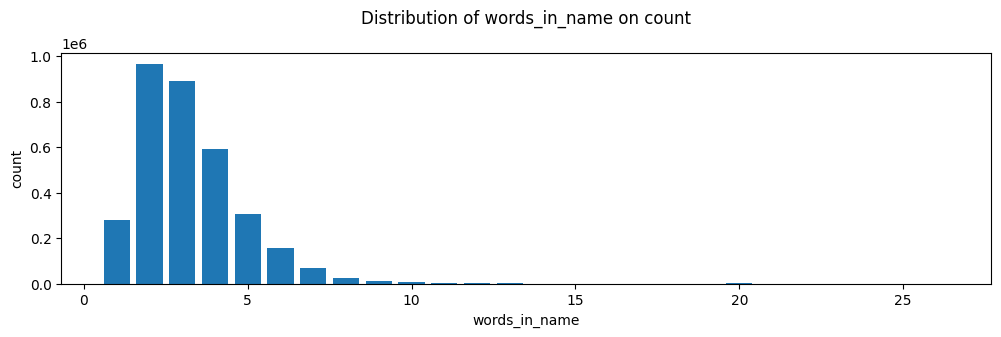

In [63]:
plot_bar(df_words_in_name_count, 'words_in_name', 'count')

>* Данные распределены неравномерно, начиная с 7 слов в наименовании блюда.

Выведение на экран образца элемента с наименованием с более чем 7 словами:

In [64]:
data_train.query('words_in_name > 7')['name'].unique()[0]

'aglio olio crispy with red onion bell pepper and crispy shallot'

Выведение на экран количества записей с заданным порогом количества слов в наименованиях блюд и их доли относительно всего набора данных:

In [65]:
print_share(
    'words_in_name > 7', 
    data_train.query('words_in_name > 7').shape[0],
    data_train
)

Words_in_name > 7: 52378
Share of words_in_name > 7 to total train data: 1.58 %


>* Необходимо убрать из набора данных строки с количеством словв наименованиях блюд свыше 7.

Удаление строк с названиями, количество слов в которых `> 7` из наборов данных:

In [66]:
drop_names = lambda x: x.query('words_in_name <= 7').reset_index(drop=True)

data_train = drop_names(data_train)
data_test = drop_names(data_test)

Удаление столбца с количеством слов в названии блюд:

In [67]:
drop_col = lambda x: x.drop('words_in_name', axis=1)

data_train = drop_col(data_train)
data_test = drop_col(data_test)

Выведение на экран размеров наборов данных до и после преобразований:

In [68]:
print('Train data initial shape:', data_train_init_shape)
print('Test data initial shape:', data_test_init_shape)

print('\nTrain data updated shape:', data_train.shape)
print('Test data updated shape:', data_test.shape)

Train data initial shape: (3431980, 13)
Test data initial shape: (591153, 13)

Train data updated shape: (3257915, 13)
Test data updated shape: (560450, 13)


---

### 3.2 Аугментация данных

**Столбец `order_time`**

>* В столбце содержится время в формате HH:MM:SS, которое можно разбить и представить по отдельности как часы и минуты.

Добавление в наборы данных столбцов с часами, минутами и секундами:

In [69]:
split_order_time = lambda df: np.array([np.int64(vals) for vals in df['order_time'].str.split(':')])

splitted_order_time_train = split_order_time(data_train)
splitted_order_time_test = split_order_time(data_test)

data_train['hour'] = splitted_order_time_train[:, 0]
data_train['minute'] = splitted_order_time_train[:, 1]

data_test['hour'] = splitted_order_time_test[:, 0]
data_test['minute'] = splitted_order_time_test[:, 1]

Выведение на экран первых строк набора данных для проверки применённых изменений:

In [70]:
data_train.head(3)

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_vendor,primary_cuisine,hour,minute
0,f374c8c54c,w21zt,1,21830106,f245bdf79350,4,19:03:03,61,chicken cutlet with rice,0.0020,undefined,w21zt,western,19,3
1,c7b610f30b,w21zt,603254,21830106,f245bdf79350,2,18:50:37,3,chicken cutlet with rice,0.0020,undefined,w21zt,western,18,50
2,f374c8c54c,w21zt,1,21830106,146127be77d4,4,19:03:03,61,chicken chop,0.0028,undefined,w21zt,western,19,3


>* Часы можно подразделить по времени суток на:
>
>    * `morning` - от 4 часов до 12 часов
>    * `day` - от 12 часов до 16 часов
>    * `evening` - от 16 часов до 24 часов
>    * `night` - от 23 часов до 4 часов

Добавление в наборы данных столбца с временем суток:

In [71]:
add_time_of_day = lambda x: 'morning' if 4 <= x < 12 else \
                            'day' if 12 <= x < 16 else \
                            'evening' if 16 <= x < 24 else \
                            'night'

data_train['time_of_day'] = data_train['hour'].apply(add_time_of_day)
data_test['time_of_day'] = data_test['hour'].apply(add_time_of_day)

Выведение на экран первых строк набора данных для проверки применённых изменений:

In [72]:
data_train.head(3)

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_vendor,primary_cuisine,hour,minute,time_of_day
0,f374c8c54c,w21zt,1,21830106,f245bdf79350,4,19:03:03,61,chicken cutlet with rice,0.0020,undefined,w21zt,western,19,3,evening
1,c7b610f30b,w21zt,603254,21830106,f245bdf79350,2,18:50:37,3,chicken cutlet with rice,0.0020,undefined,w21zt,western,18,50,evening
2,f374c8c54c,w21zt,1,21830106,146127be77d4,4,19:03:03,61,chicken chop,0.0028,undefined,w21zt,western,19,3,evening


---

**Столбец `unit_price`**

Выведение на экран уникальных значений столбца:

In [73]:
data_train['unit_price'].sort_values().unique()

array([0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028, 0.0032,
       0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 , 0.0064,
       0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092, 0.0096,
       0.01  , 0.0104, 0.0108, 0.0112, 0.0116, 0.012 , 0.0124, 0.0128,
       0.0132, 0.0136, 0.014 , 0.0144, 0.0148, 0.0152, 0.0156, 0.016 ,
       0.0164, 0.0168, 0.0172, 0.0176, 0.018 , 0.0184, 0.0188, 0.0192,
       0.0196, 0.02  , 0.0204, 0.0208, 0.0212, 0.0216, 0.022 , 0.0224,
       0.0228, 0.0232, 0.0236, 0.024 , 0.0244, 0.0248, 0.0252, 0.0256,
       0.026 , 0.0264, 0.0268, 0.0272, 0.0276, 0.028 , 0.0284, 0.0288,
       0.0292, 0.0296, 0.03  , 0.0304, 0.0308, 0.0312, 0.0316, 0.032 ,
       0.0324, 0.0328, 0.0332, 0.0336, 0.034 , 0.0344, 0.0352, 0.0356,
       0.036 , 0.0364, 0.0368, 0.0372, 0.0376, 0.038 , 0.0384, 0.0388,
       0.0392, 0.0396, 0.04  , 0.0404, 0.0408, 0.0412, 0.0416, 0.042 ,
       0.0424, 0.0428, 0.0432, 0.0436, 0.044 , 0.0448, 0.0452, 0.0456,
      

>Значения можно подразделить на группы:
>
>* `<0.001`
>* `0.001-0.002`
>* `0.002-0.003`
>* `0.003-0.004`
>* `0.004-0.005`
>* `0.005-0.01`
>* `>0.01`

Категоризация значений столбца в наборах данных:

In [74]:
get_unit_price_category = lambda x: '<0.001' if x < 0.001 else \
                                    '0.001-0.002' if 0.001 <= x < 0.002 else \
                                    '0.002-0.003' if 0.002 <= x < 0.003 else \
                                    '0.003-0.004' if 0.003 <= x < 0.004 else \
                                    '0.004-0.005' if 0.004 <= x < 0.005 else \
                                    '0.005-0.01' if 0.005 <= x < 0.01 else \
                                    '>0.01'

data_train['unit_price_category'] = data_train['unit_price'].apply(get_unit_price_category)
data_test['unit_price_category'] = data_test['unit_price'].apply(get_unit_price_category)

Выведение на экран количественного соотношения значений столбца для проверки применённых изменений:

In [75]:
data_train['unit_price_category'].value_counts()

unit_price_category
0.002-0.003    867563
0.001-0.002    535548
0.005-0.01     461588
0.003-0.004    440755
<0.001         430901
0.004-0.005    409320
>0.01          112240
Name: count, dtype: int64

---

**Столбцы `geohash` и `geohash_vendor`**

Задание функции, конвертирующей хэш-идентификаторы геопозиций в широту и долготу:

In [76]:
def decode_hash(code: str) -> Tuple[float]:
    '''Decode geo hash to latitude and longitude.
    
    Args:
      - code (str) - hash code
    '''
    
    decoded = geohash2.decode(code)
    
    return (float(decoded[0]), float(decoded[1]))

Задание функции, вычисляющей расстояние по прямой от геолокации покупателя до геолокации продавца:

In [77]:
def calculate_distance(row) -> float:
    '''Calculate distance from customer to vendor.
    
    Args:
    - row - row of dataframe during df.apply(calculate_distance, axis=1)
    '''
    
    return round(geodesic(row['user_lat_lon'], row['vendor_lat_lon']).km, 2)

---

Выведение на экран уникальных значений столбцов:

In [78]:
for col in ['geohash', 'geohash_vendor']:
    print(col.upper(), len(data_train[col].unique()))
    print(data_train[col].sort_values().unique())
    print('\n---\n')

GEOHASH 45
['w21xj' 'w21xm' 'w21xn' 'w21xp' 'w21xq' 'w21xr' 'w21xw' 'w21xx' 'w21xz'
 'w21z1' 'w21z2' 'w21z3' 'w21z4' 'w21z5' 'w21z6' 'w21z7' 'w21z8' 'w21z9'
 'w21zb' 'w21zc' 'w21zd' 'w21ze' 'w21zf' 'w21zg' 'w21zk' 'w21zm' 'w21zq'
 'w21zr' 'w21zs' 'w21zt' 'w21zu' 'w21zv' 'w21zw' 'w21zx' 'w21zy' 'w21zz'
 'w238p' 'w23b0' 'w23b1' 'w23b3' 'w23b4' 'w23b5' 'w23b6' 'w23b7' 'w23bh']

---

GEOHASH_VENDOR 31
['w21xr' 'w21xx' 'w21z2' 'w21z3' 'w21z4' 'w21z5' 'w21z6' 'w21z7' 'w21z8'
 'w21z9' 'w21zb' 'w21zc' 'w21zd' 'w21ze' 'w21zf' 'w21zg' 'w21zk' 'w21zm'
 'w21zs' 'w21zt' 'w21zu' 'w21zv' 'w21zw' 'w21zy' 'w23b0' 'w23b1' 'w23b3'
 'w23b4' 'w23b5' 'w23b6' 'w23bh']

---



Выведение на экран количества непересекающихся значений столбцов:

In [79]:
print(
    'Not in the intersection:',
    len(set(data_train['geohash']) ^ set(data_train['geohash_vendor']))
)

Not in the intersection: 14


>* Поскольку из значений хэш-идентификаторов можно извлечь широту и долготу, можно определить расстояние по прямой между покупателем и продавцом:
>
>    * `0.0` - если значения хэш-идентификаторов совпадают.
>    * вычисляемое расстояние - если не совпадают, с округлением до одного знака после запятой.

Конвертация хэш-идентификаторов в широту и долготу:

In [80]:
data_train['user_lat_lon'] = data_train['geohash'].apply(decode_hash)
data_train['vendor_lat_lon'] = data_train['geohash_vendor'].apply(decode_hash)

data_test['user_lat_lon'] = data_test['geohash'].apply(decode_hash)
data_test['vendor_lat_lon'] = data_test['geohash_vendor'].apply(decode_hash)

Выведение на экран первых строк набора данных для проверки применённых изменений:

In [81]:
data_train.head(3)

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_vendor,primary_cuisine,hour,minute,time_of_day,unit_price_category,user_lat_lon,vendor_lat_lon
0,f374c8c54c,w21zt,1,21830106,f245bdf79350,4,19:03:03,61,chicken cutlet with rice,0.0020,undefined,w21zt,western,19,3,evening,0.002-0.003,"(1.3, 104.0)","(1.3, 104.0)"
1,c7b610f30b,w21zt,603254,21830106,f245bdf79350,2,18:50:37,3,chicken cutlet with rice,0.0020,undefined,w21zt,western,18,50,evening,0.002-0.003,"(1.3, 104.0)","(1.3, 104.0)"
2,f374c8c54c,w21zt,1,21830106,146127be77d4,4,19:03:03,61,chicken chop,0.0028,undefined,w21zt,western,19,3,evening,0.002-0.003,"(1.3, 104.0)","(1.3, 104.0)"


Вычисление расстояния между покупателем и продавцом:

In [82]:
data_train['distance_to_vendor'] = data_train.apply(calculate_distance, axis=1)
data_test['distance_to_vendor'] = data_test.apply(calculate_distance, axis=1)

Выведение на экран первых строк набора данных для проверки применённых изменений:

In [83]:
data_train.head(3)

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_vendor,primary_cuisine,hour,minute,time_of_day,unit_price_category,user_lat_lon,vendor_lat_lon,distance_to_vendor
0,f374c8c54c,w21zt,1,21830106,f245bdf79350,4,19:03:03,61,chicken cutlet with rice,0.0020,undefined,w21zt,western,19,3,evening,0.002-0.003,"(1.3, 104.0)","(1.3, 104.0)",0.0
1,c7b610f30b,w21zt,603254,21830106,f245bdf79350,2,18:50:37,3,chicken cutlet with rice,0.0020,undefined,w21zt,western,18,50,evening,0.002-0.003,"(1.3, 104.0)","(1.3, 104.0)",0.0
2,f374c8c54c,w21zt,1,21830106,146127be77d4,4,19:03:03,61,chicken chop,0.0028,undefined,w21zt,western,19,3,evening,0.002-0.003,"(1.3, 104.0)","(1.3, 104.0)",0.0


Выведение на экран уникальных значений столбца:

In [84]:
data_train['distance_to_vendor'].value_counts()

distance_to_vendor
0.00     2658642
11.13     375561
11.06     181048
15.69      28644
22.26       7386
24.85       2507
33.39       2130
24.76       1101
35.17        321
22.11        317
31.38        258
Name: count, dtype: int64

>Значения можно подразделить на группы:
>
>* `0`
>* `0-20`
>* `>20`

Категоризация значений столбца в наборах данных:

In [85]:
get_distance_category = lambda x: '0' if x == 0 else \
                                  '0-20' if 10 < x < 20 else \
                                  '>20'

data_train['distance_to_vendor_category'] = data_train['distance_to_vendor'].apply(get_distance_category)
data_test['distance_to_vendor_category'] = data_test['distance_to_vendor'].apply(get_distance_category)

Выведение на экран уникальных значений столбца:

In [86]:
data_train['distance_to_vendor_category'].value_counts()

distance_to_vendor_category
0       2658642
0-20     585253
>20       14020
Name: count, dtype: int64

**Вывод**

>* Данные были подготовлены для проведения исследовательского анализа.

---

## 4 Исследовательский анализ данных

Задание функции, выводящей график количественного распределения значений в столбце:

In [87]:
def plot_bar_count(df: pd.DataFrame, 
                   col_name: str, 
                   shift_x: float = -0.2, 
                   plot_text: bool = True,
                   xticks_rotation: int = 0) -> None:
    
    '''Plot bar of .value_counts().
    
    Args:
    - df (pd.DataFrame) - initial dataframe
    - col_name (str) - column name
    - shift_x (float, optional) - value to shift text on bars. Defaults to -0.2
    - plot_text (bool, optional) - print or not text on bars. Defaults to True
    - xticks_rotation (int, optional) - X axis labels rotation degrees. Defaults to 0
    '''
    
    plt.figure(figsize=(12, 3))
    plt.title(f'Unique values distribution on {col_name}\n', fontsize=12)
    
    df_count = pd.DataFrame(df[col_name].value_counts()).sort_values(by=col_name).reset_index()
    plt.bar(df_count[col_name], df_count['count'])

    if plot_text:
        for i in range(df_count.shape[0]):
            row = df_count.loc[i]
            
            if type(row[col_name]) is str:
                x = i
            else:
                x = row[col_name]
            
            y = row['count']
            shift_y = y / 3
            
            plt.text(x + shift_x, y - shift_y, str(y), color='black', fontsize=10)
    
    if xticks_rotation != 0:
        plt.xticks(fontsize=8, rotation=xticks_rotation)
    
    plt.xlabel(col_name)
    plt.ylabel('frequency')
    
    plt.show()

Задание функции, выводящей график распределения значений одного столбца по другому столбцу:

In [88]:
def plot_multi_bar(df: pd.DataFrame, col_name: str, col_target: str, y_frac: float = 1) -> None:
    '''Plot bultiple bars depending on another column.
    
    Args:
    - df (pd.DataFrame) - initial dataframe
    - col_name (str) - column name
    - col_target (str) - another column name
    - y_frac (float, optional) - fraction to manage plot height. Defaults to 1
    '''
    
    df_count = pd.pivot_table(
        df[['customer_id', col_name, col_target]],
        columns=col_name,
        index=col_target,
        aggfunc='count'
    ).reset_index()
    
    df_count.columns = [col if col != '' else key for key, col in df_count.columns]
    
    df_count.plot(
        x=col_target, 
        kind='barh', 
        stacked=False, 
        figsize=(12, y_frac * len(df_count[col_target])),
        title=f'Distribution of {col_name} over {col_target}\n',
        xlabel='frequency',
        width=0.8,
        edgecolor='black',
        lw=0.4
    ) 
         
    plt.legend()
    plt.show()

Задание функции, выводящей облако слов:

In [89]:
def plot_wordcloud(data: pd.Series) -> None:
    '''Plot cloud of words.
    
    Args:
    - data (pd.Series) - dataframe column
    '''
    
    text = ' '.join(name for name in data)
    
    word_cloud = WordCloud(
        collocations=False,
        background_color='white',
        width=2048*2,
        height=1080
    ).generate(text)
    
    
    plt.figure(figsize=(12, 6))
    plt.imshow(word_cloud, interpolation='bilinear')
    
    plt.axis('off')
    plt.show()

---

**Столбец `primary_cuisine`**

>* Столбец `primary_cuisine` является целевым признаком.
>* Необходимо определить важные признаки для составления рекомендательной системы.

Выведение на экран количества уникальных значений в столбце:

In [90]:
print('Unique values:', len(data_train['primary_cuisine'].unique()))

Unique values: 78


Выведение на экран количественного соотношения значений в столбце:

In [91]:
data_train['primary_cuisine'].value_counts()

primary_cuisine
chinese       330642
indian        235303
dessert       160408
noodles       137604
bubble tea    137287
               ...  
shawarma         392
lebanese         129
grain bowl        87
spanish           53
ice cream         13
Name: count, Length: 78, dtype: int64

Выведение на экран облака слов в столбце:

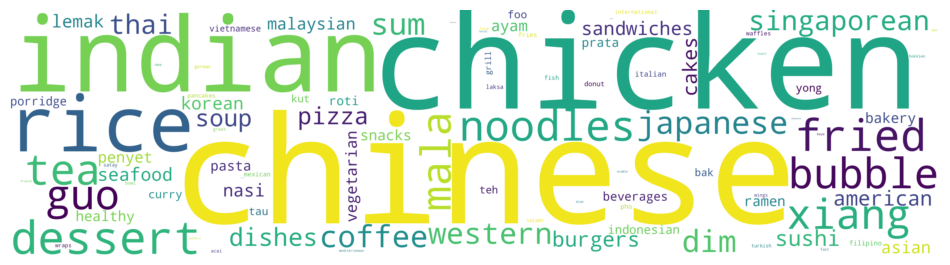

In [92]:
plot_wordcloud(data_train['primary_cuisine'])

>* Среди слов, встречающихся в названиях кухонь, наиболее распространены: `chinese`, `chicken`, `indian`, `dessert`, `fried`, `fice`, `tea`.

---

**Столбец `day_of_week`**

Выведение на экран количественного распределения значений в столбце:

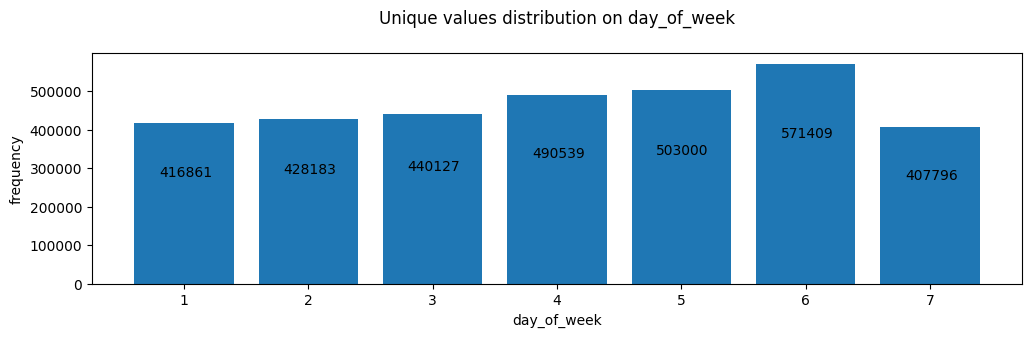

In [93]:
plot_bar_count(data_train, 'day_of_week')

Выведение на экран количественного распределения значений в столбце по целевому признаку:

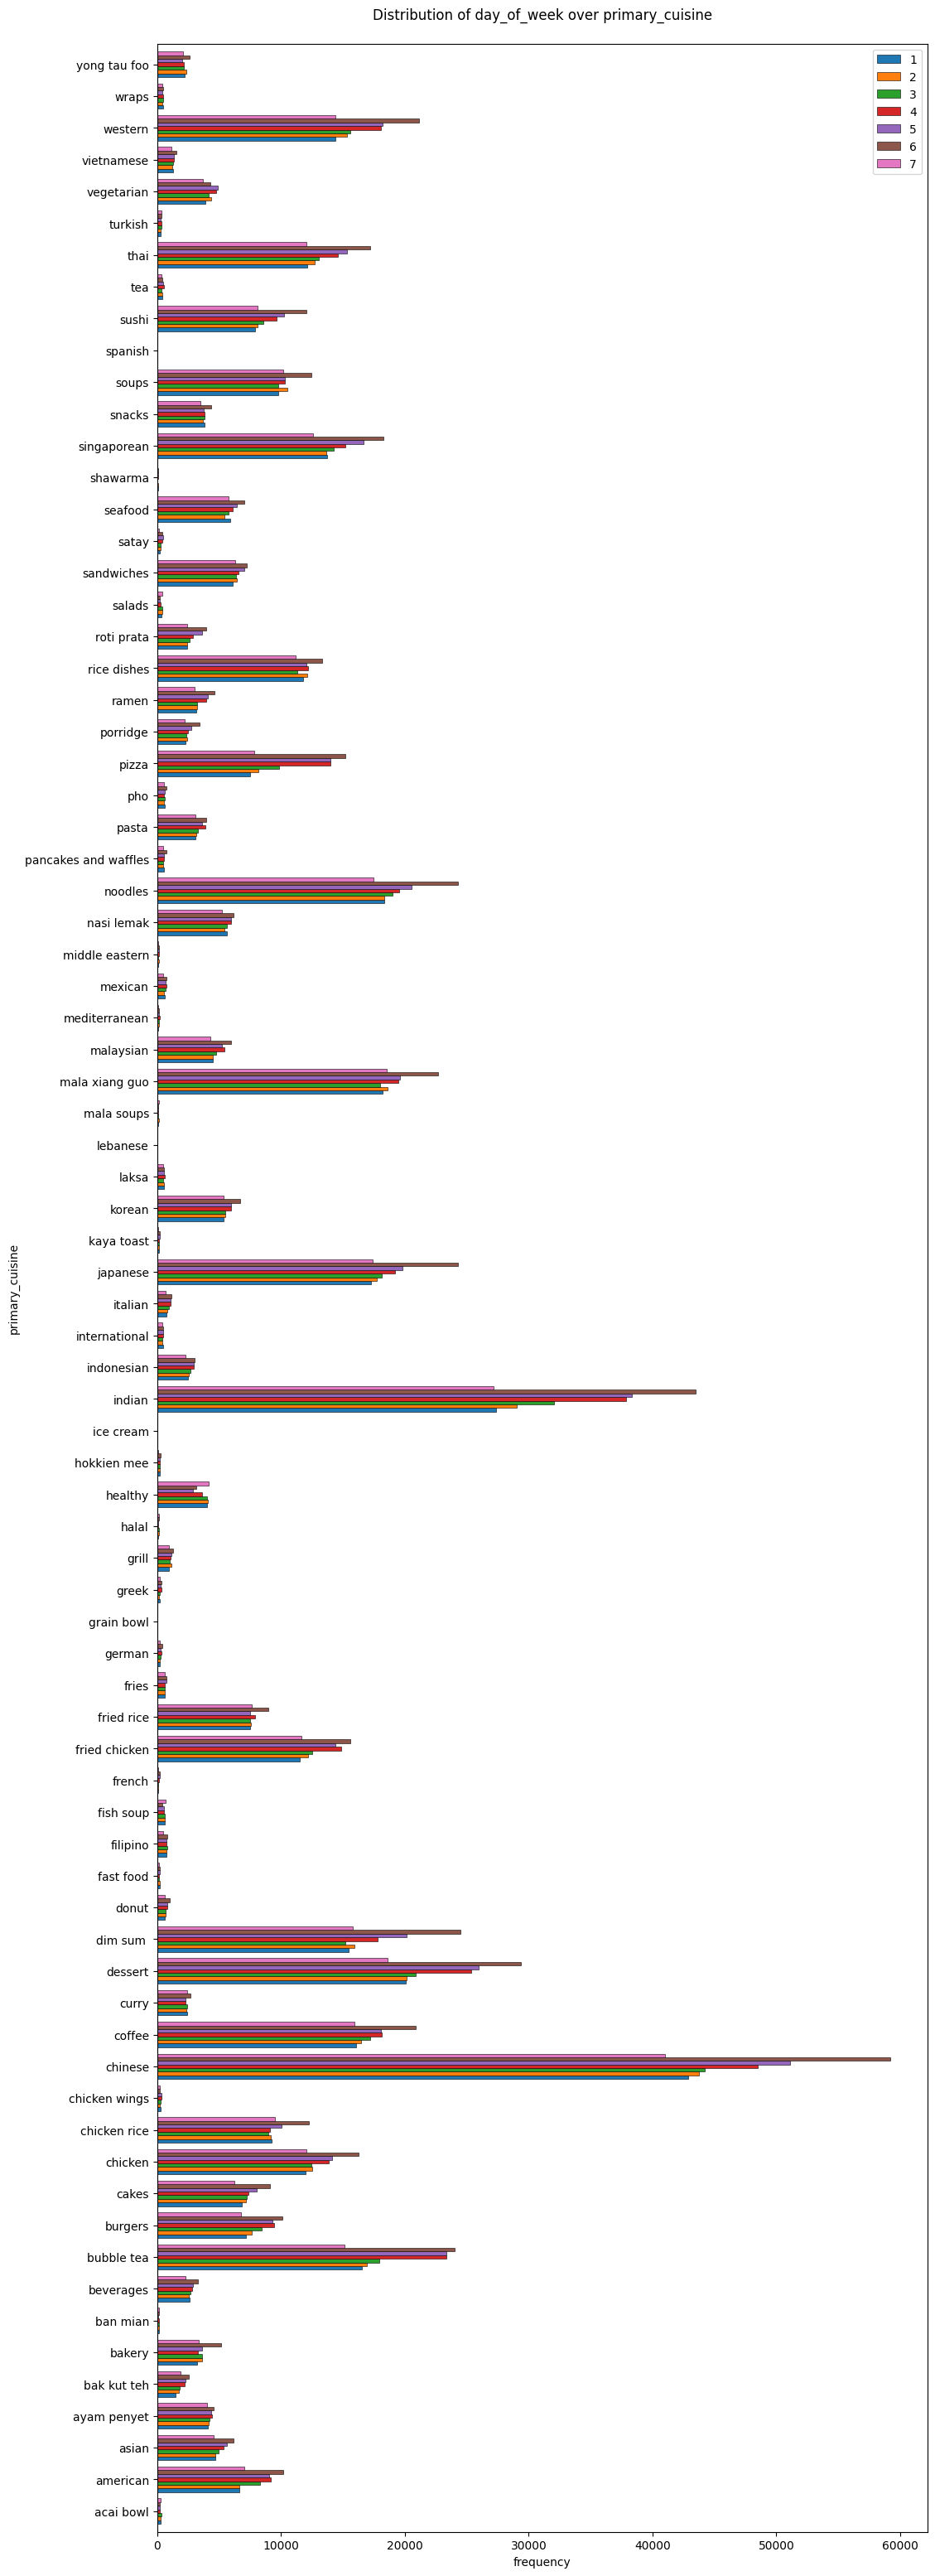

In [94]:
plot_multi_bar(
    data_train, 
    col_name='day_of_week', 
    col_target='primary_cuisine', 
    y_frac=0.5
)

>* В целом разница в количестве заказов в зависимости от дня недели отсутствует.
>* Вне зависимости от кухни чаще всего заказы оформляются в субботу, а реже всего - в понедельник.
>* Также можно выделить наиболее популярные виды кухонь, однако это связано с их количественным распределением во всём наборе данных.

---

**Столбец `order_day`**

Выведение на экран количественного распределения значений в столбце:

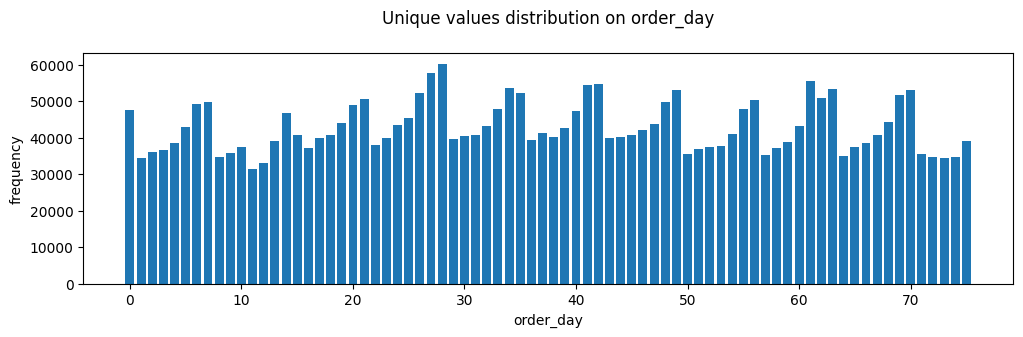

In [95]:
plot_bar_count(data_train, 'order_day', plot_text=False)

>* В целом разница в количестве заказов в зависимости от количества дней с момента прошлого заказа отсутствует.
>* Можно заметить тенденцию к увеличению числа заказов примерно каждые 10 дней, однако это наблюдение не связано с поставленной задачей.

---

**Столбец `name`**

Выведение на экран облака слов в столбце:

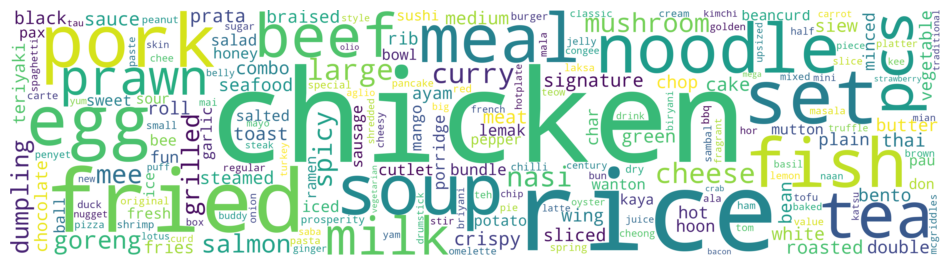

In [96]:
plot_wordcloud(data_train['name'])

>* Среди названий блюд наиболее популярны: `chicken`, `rice`, `egg`, `fried`, `set`, `soup`, `fish`, `pork`, `tea`, `beef`, `noodle`, `prawn`, `meal`.

---

**Столбец `unit_price_category`**

Выведение на экран количественного распределения значений в столбце:

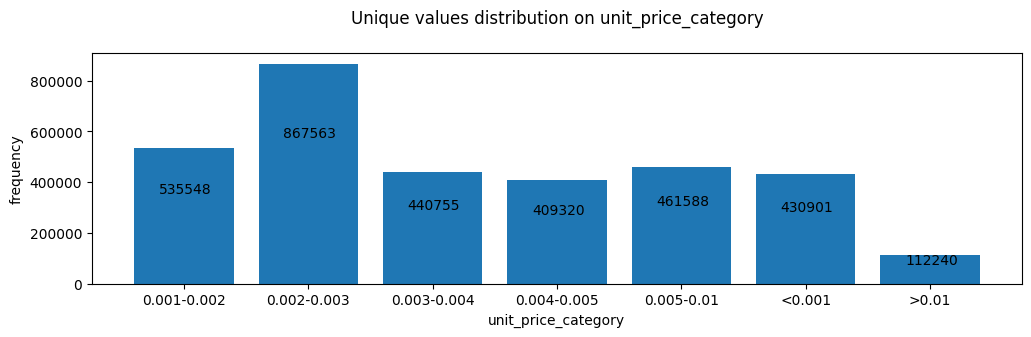

In [97]:
plot_bar_count(data_train, 'unit_price_category')

Выведение на экран количественного распределения значений в столбце по целевому признаку:

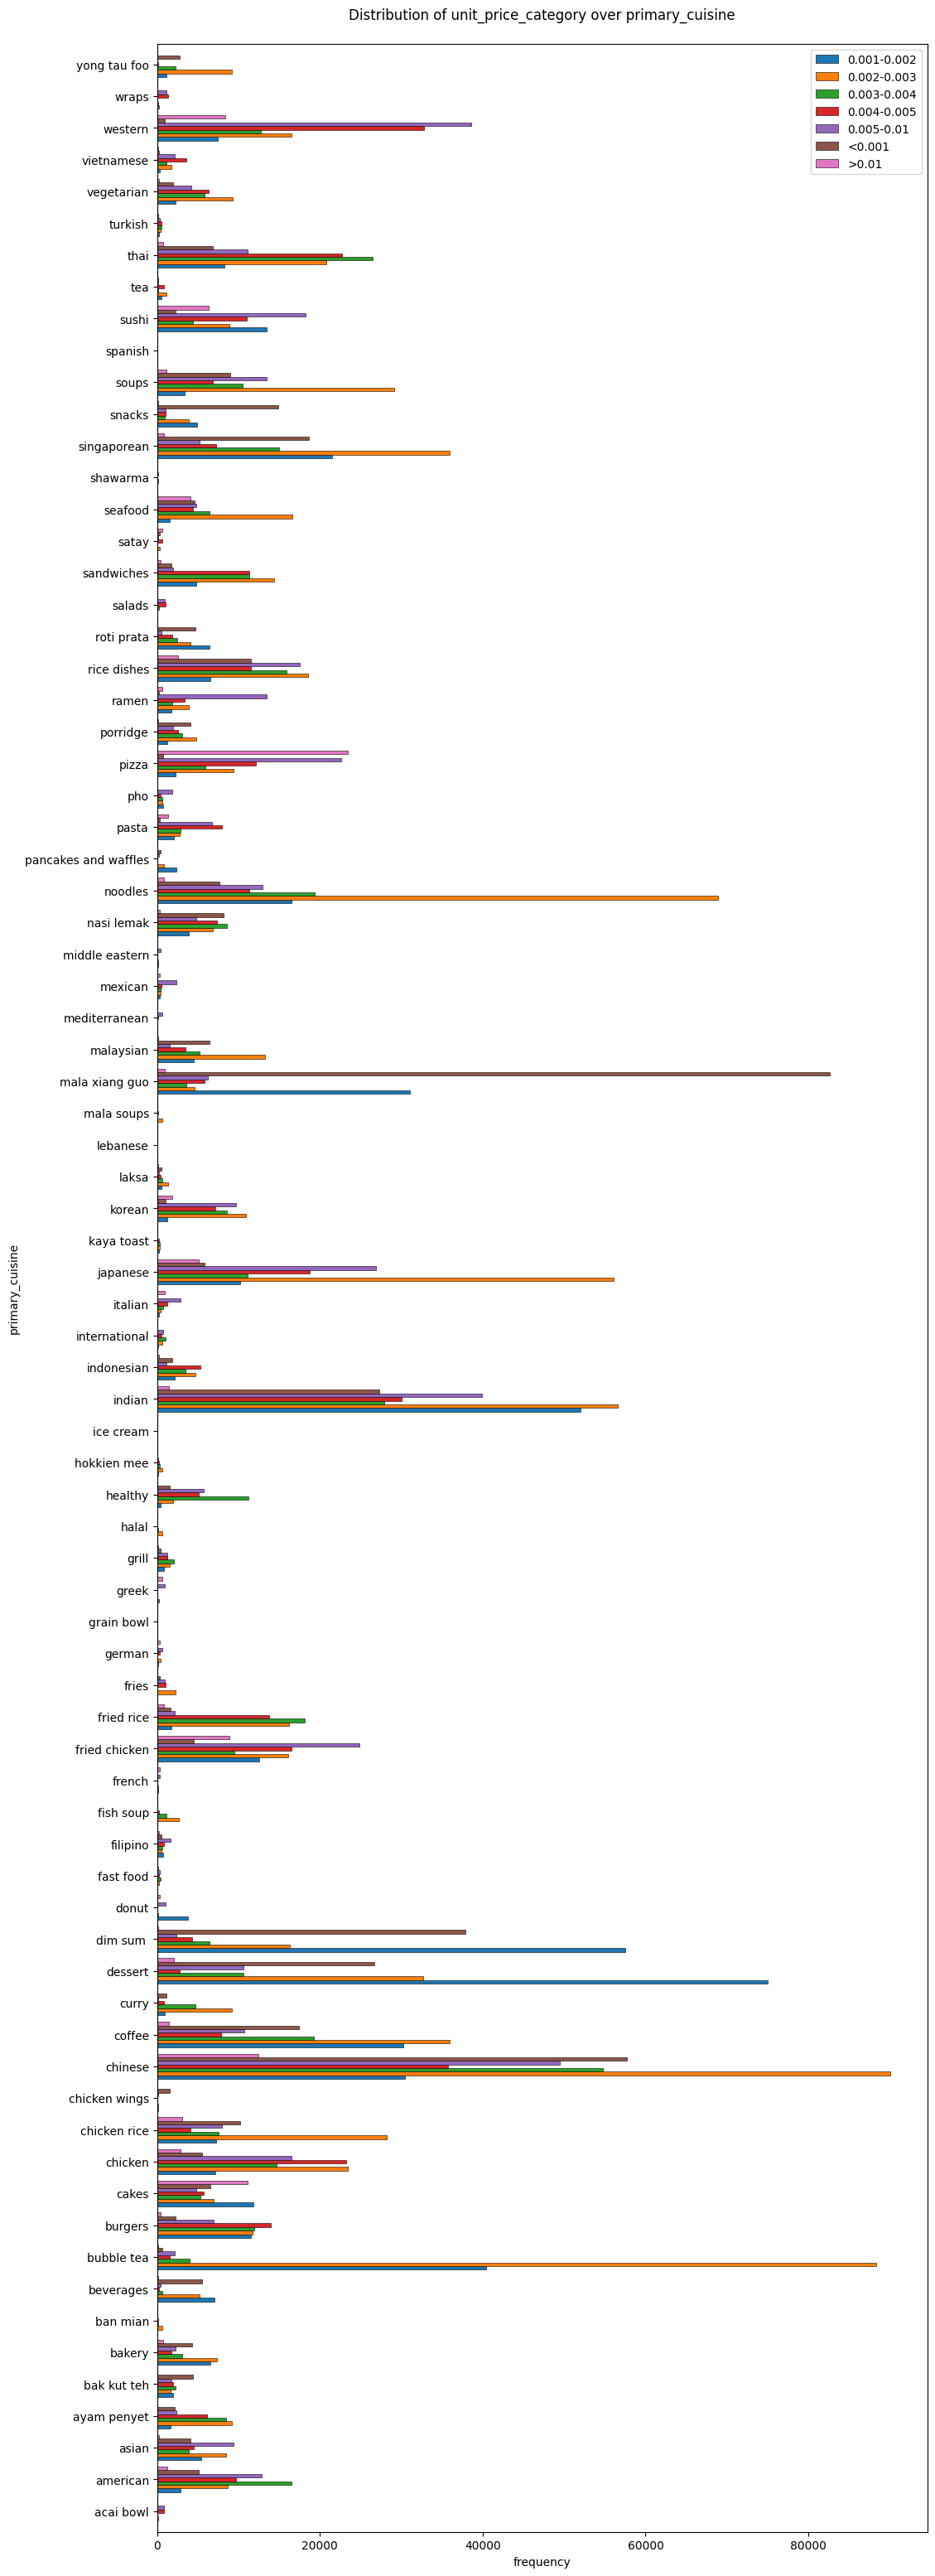

In [98]:
plot_multi_bar(
    data_train, 
    col_name='unit_price_category', 
    col_target='primary_cuisine', 
    y_frac=0.5
)

>* Стоимость за единицу продукта разнится в зависимости от типа кухни, однако она не влияет на выбор кухни.
>* В документации не указана точная валюта, указанная в столбце, поэтому нет возможности использовать данный признак при составлении итогового набора данных.

---

**Столбец `hour`**

Выведение на экран количественного распределения значений в столбце:

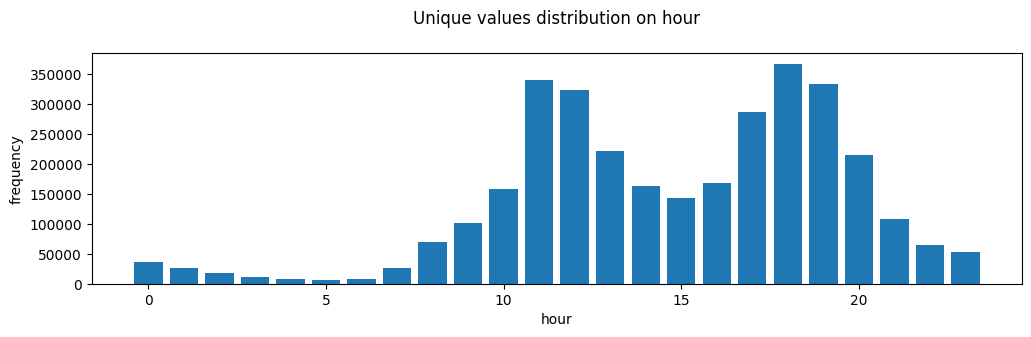

In [99]:
plot_bar_count(data_train, 'hour', plot_text=False)

Выведение на экран количественного распределения значений в столбце по целевому признаку:

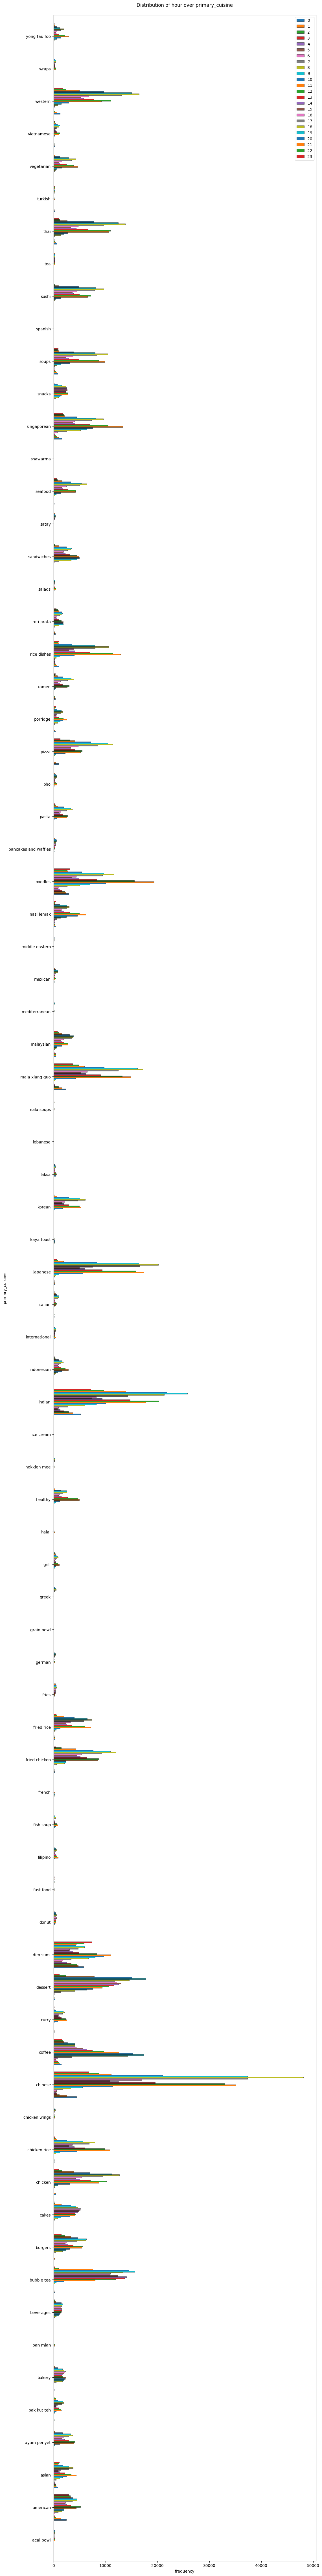

In [100]:
plot_multi_bar(
    data_train, 
    col_name='hour', 
    col_target='primary_cuisine', 
    y_frac=1.5
)

>* Частота заказов связана с временем в часах, когда они были оформлены.
>* В основном заказы оформляются в промежуток 10-13 часов и 17-20 часов.

---

**Столбец `minute`**

Выведение на экран количественного распределения значений в столбце:

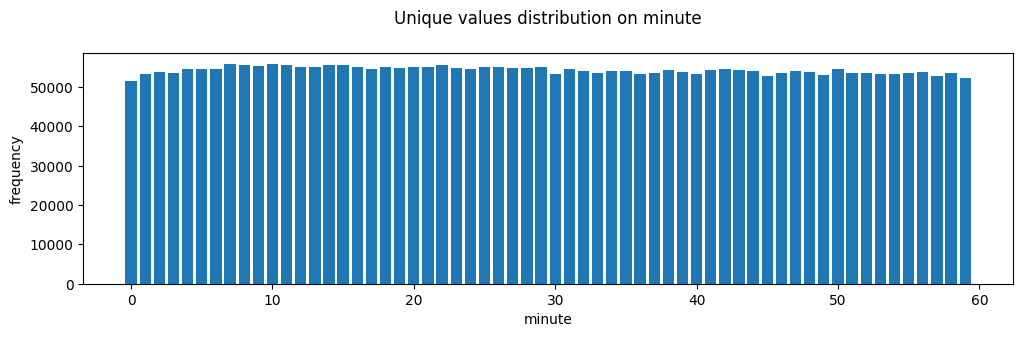

In [101]:
plot_bar_count(data_train, 'minute', plot_text=False)

>* Количественное распределение значений по минутам заказа едино для всего набора данных.

---

**Столбец `time_of_day`**

Выведение на экран количественного распределения значений в столбце:

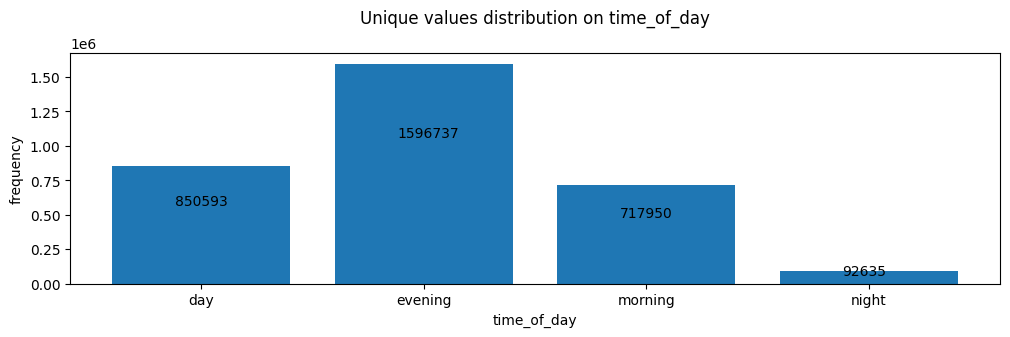

In [102]:
plot_bar_count(data_train, 'time_of_day', shift_x=-0.12)

Выведение на экран количественного распределения значений в столбце по целевому признаку:

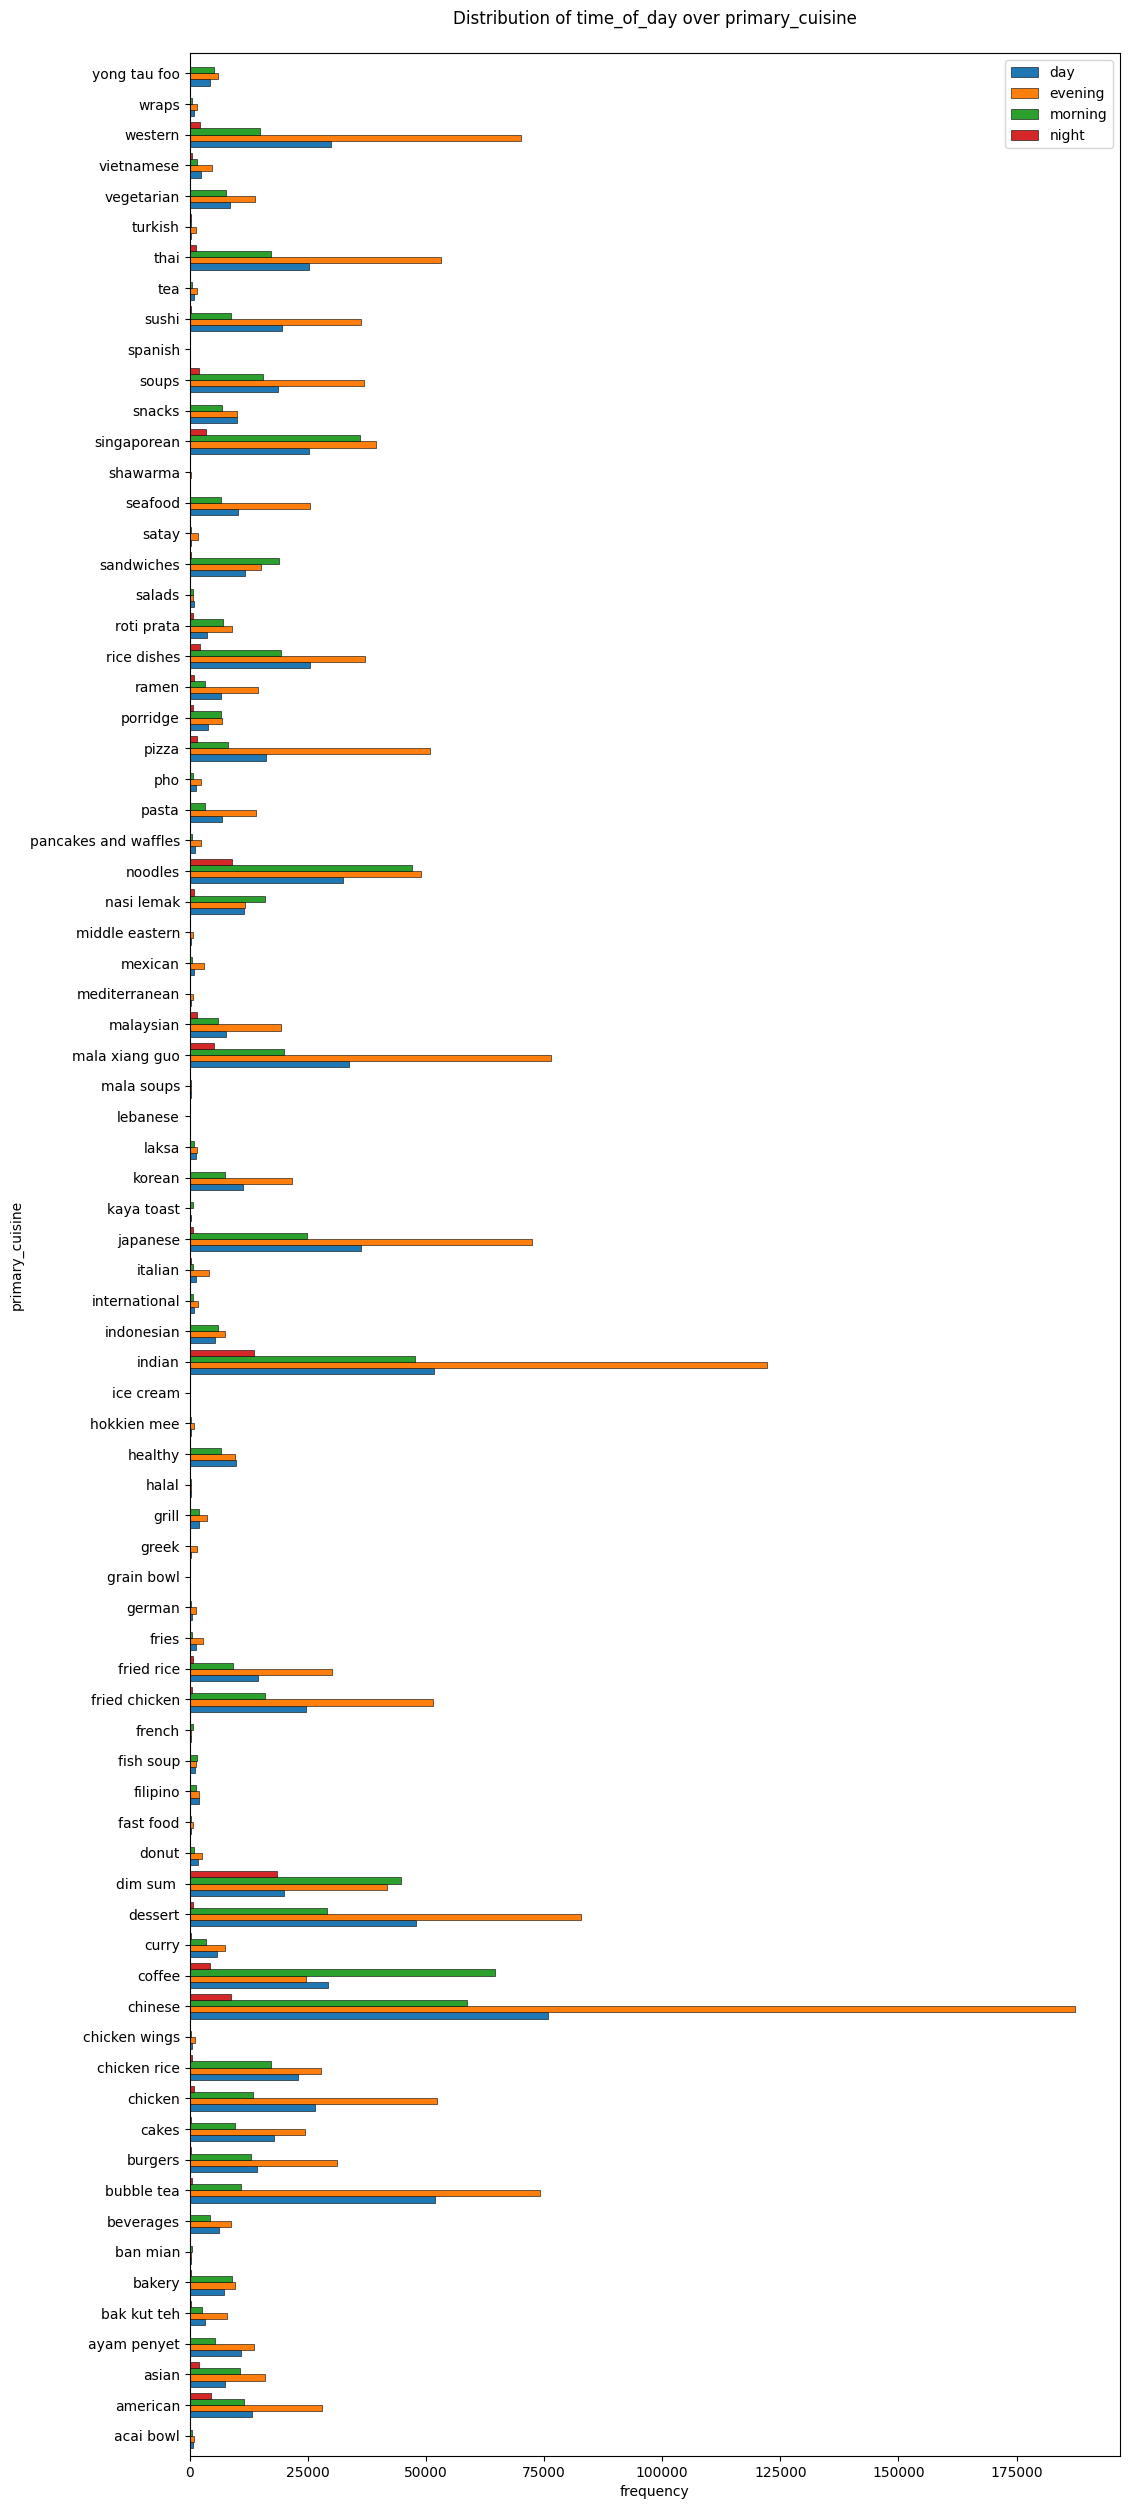

In [103]:
plot_multi_bar(
    data_train, 
    col_name='time_of_day', 
    col_target='primary_cuisine', 
    y_frac=0.4
)

>* Основное время суток, на которые приходятся заказы - это вечер.

---

**Столбец `distance_to_vendor_category`**

Выведение на экран количественного распределения значений в столбце по целевому признаку:

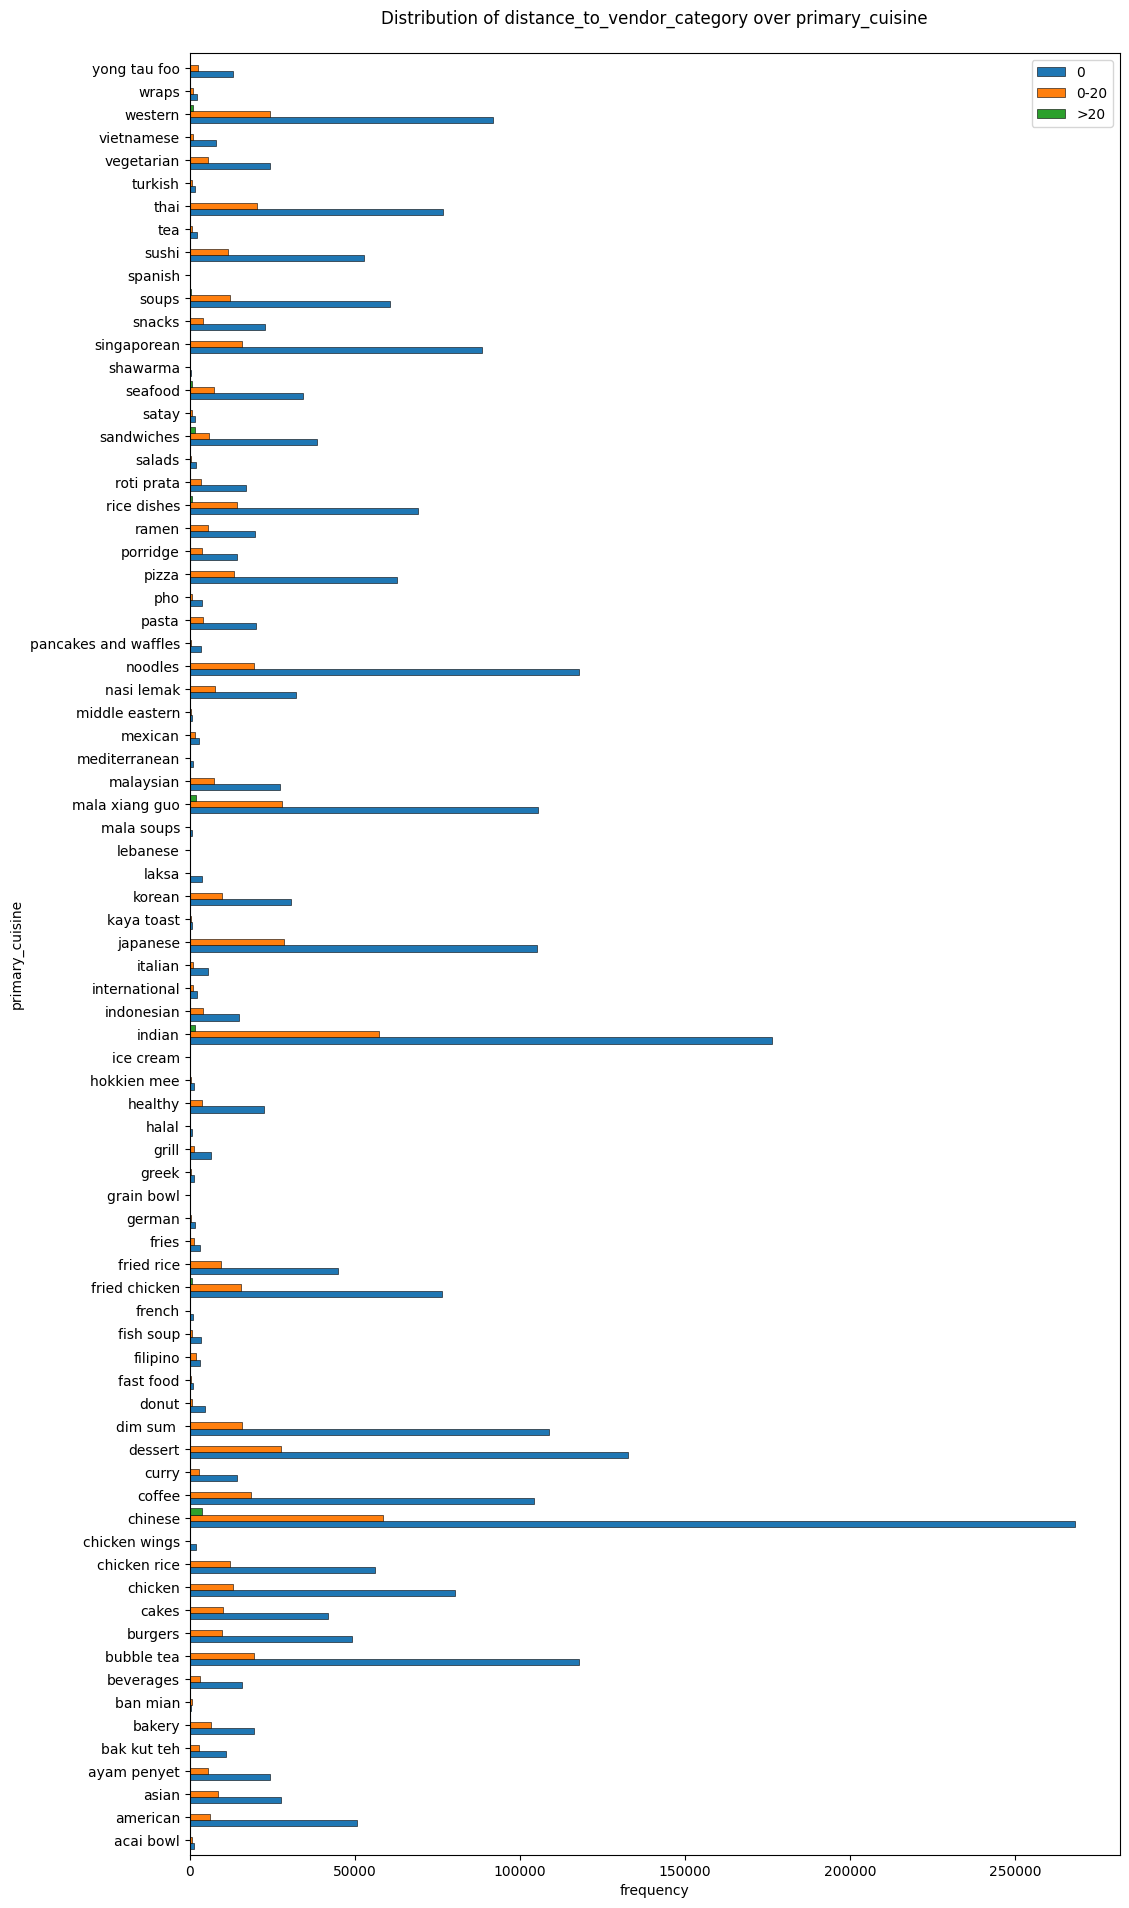

In [104]:
plot_multi_bar(
    data_train, 
    col_name='distance_to_vendor_category', 
    col_target='primary_cuisine', 
    y_frac=0.3
)

>* В основном все заказы оформляются в том же районе, где находится покупатель.

>**Вывод**
>
>* Было установлено, что с целевым признаком связаны следующие признаки: `name`, `hour`, `time_of_day`, `vendor_lat_lon`.

---

## 5 Отбор признаков

Задание функции, выводящей матрицу корреляции признаков:

In [105]:
def plot_corr_matrix(df: pd.DataFrame, fig_size: Tuple[float]) -> None:
    '''Plot correlation matrix.
    
    Args:
    - df (pd.DataFrame) - initial dataframe
    - fig_size (Tuple[float]) - plot size
    '''
    
    data_corr = df.phik_matrix().round(2)
    
    plot_correlation_matrix(data_corr.values, 
                            x_labels=data_corr.columns, 
                            y_labels=data_corr.index, 
                            vmin=0, 
                            vmax=1, 
                            color_map='Blues', 
                            title='Correlation matrix\n', 
                            fontsize_factor=0.8, 
                            figsize=fig_size)
    
    plt.tight_layout()
    plt.show()

---

Формирование списка признаков, оказывающих влияние на целевой признак:

In [106]:
features = [
    'name',
    'vendor_lat_lon',
    'hour',
    'time_of_day',
    'primary_cuisine'
]

Выведение на экран матрицы корреляции признаков:

interval columns not set, guessing: ['hour']


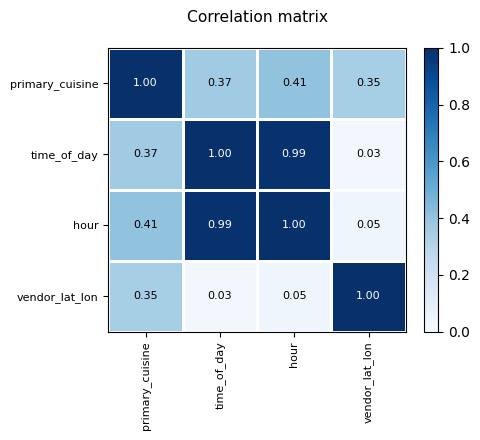

In [107]:
df_corr_train = plot_corr_matrix(data_train[features].drop('name', axis=1), fig_size=(5, 4.5))

>* Все признаки действительно коррелируют с целевым признаком.

Задание обучающей и тестовой выборок с отобранными признаками:

In [108]:
X_train = data_train[features]
X_test = data_test[features]

Выведение на экран количества явных дубликатов:

In [109]:
print('Total duplicates:', X_train.duplicated().sum())

Total duplicates: 2401299


Удаление явных дубликатов:

In [110]:
X_train = X_train.drop_duplicates().reset_index(drop=True)
X_test = X_test.drop_duplicates().reset_index(drop=True)

Выведение на экран размеров выборок:

In [111]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (856616, 5)
X_test shape: (306304, 5)


>В соответствии с поставленной задачей будет сохранено два вида датасетов:
>
>* Для построения модели Multi-label classification.
>* Для составления рекомендательной системы.

---

**Multi-label classification**

Сохранение наборов данных с двумя столбцами (названием блюда и названием кухни) и удаление дубликатов строк:

In [112]:
cols = ['name', 'primary_cuisine']

X_train_cuisine = X_train[cols].drop_duplicates()
X_test_cuisine = X_test[cols].drop_duplicates()

Построение графика колчиественного распределения значений в столбце с названиями кухонь:

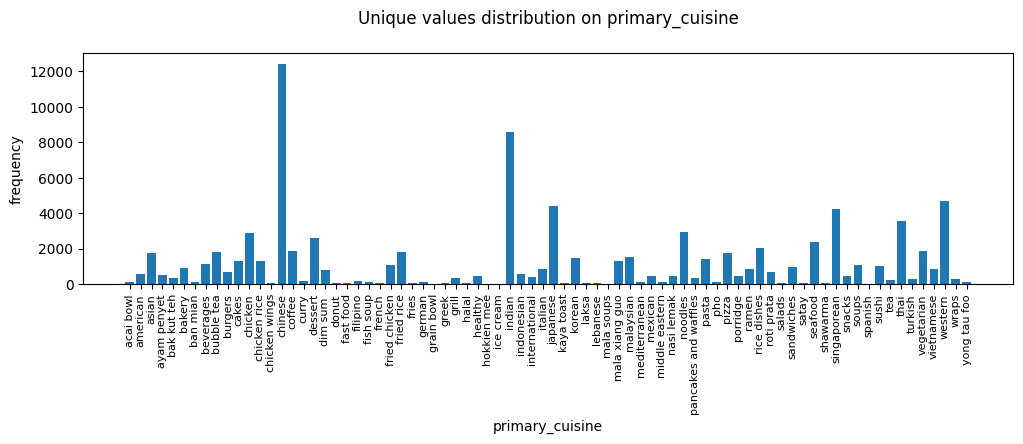

In [113]:
plot_bar_count(X_train_cuisine, 'primary_cuisine', plot_text=False, xticks_rotation=90)

Выведение на экран количества уникальных значений имён и общего количества имён:

In [114]:
print('Total unique names:', len(X_train_cuisine['name'].unique()))
print('Total names:', X_train_cuisine.shape[0])

Total unique names: 67739
Total names: 88558


Группирование названий кухонь по названиям блюд:

In [115]:
multiabel_cuisine = lambda x: x.groupby('name')['primary_cuisine'].transform(lambda x: ', '.join(x))

X_train_cuisine['multilabels'] = multiabel_cuisine(X_train_cuisine)
X_test_cuisine['multilabels'] = multiabel_cuisine(X_test_cuisine)

Выведение на экран первых строк набора данных:

In [116]:
X_train_cuisine.head(3)

,name,primary_cuisine,multilabels
0,chicken cutlet with rice,western,"western, singaporean, chicken, chinese, fried ..."
2,chicken chop,western,"western, chicken, indian, fried chicken, chine..."
9,chicken wings with rice,western,"western, chicken, asian"


Удаление столбца с названиями кухонь и дубликатов строк:

In [117]:
drop_col = lambda x: x.drop('primary_cuisine', axis=1).drop_duplicates().reset_index(drop=True)

X_train_cuisine = drop_col(X_train_cuisine)
X_test_cuisine = drop_col(X_test_cuisine)

Выведение на экран размеров выборок до и после преобразований:

In [118]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('\nX_train_cuisine shape:', X_train_cuisine.shape)
print('X_test_cuisine shape:', X_test_cuisine.shape)

X_train shape: (856616, 5)
X_test shape: (306304, 5)

X_train_cuisine shape: (67739, 2)
X_test_cuisine shape: (43625, 2)


---

**Сохранение наборов данных**

Сохранение наборов данных для построения рекомендательной системы:

In [119]:
X_train.to_csv(os.path.join(PATH, 'preprocessed_data/data_train.csv'))
X_test.to_csv(os.path.join(PATH, 'preprocessed_data/data_test.csv'))

Сохранение наборов данных для задачи Multi-label classification:

In [120]:
X_train_cuisine.to_csv(os.path.join(PATH, 'preprocessed_data/data_train_cuisine.csv'))
X_test_cuisine.to_csv(os.path.join(PATH, 'preprocessed_data/data_test_cuisine.csv'))

>**Вывод**
>
>* Были получены и сохранены данные, соответствующие поставленным перед исследованием задачам.

---

## 6 Общий вывод

В ходе проведённого исследования:

* Данные были обработаны от пропусков, неправдоподобных значений и аномалий.
* Была проведена аугментация данных и подготовлен объект кодирования данных.
* В ходе исследовательского анализа данных были выявлены значимые для поставленной задачи признаки для построения рекомендательной системы.
<br>

* Для оптимизации процесса обработки данных промежуточные этапы, требующие вычислительной сложности, были сохранены в виде отдельных файлов с целью подгрузки при их вызове. 
* Сохранено два вида датасетов: 1) для построения модели Multi-label classification; 2) для составления рекомендательной системы.
* Обучающая и тестовая выборки были сохранены в .csv-файлы и помещены в папку `data/preprocessed_data/`.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>